# Monitoring Water Saturation Variations in Landes Sand
Data from Thomas. 

*Version 2:* Modified Walton model (Pride, 2005) is used instead of Hertz-Mindlin model to estimate drained properties. This is more consistent with the velocity dependence upon pressure observed for the low pressure range (below 10 MPa).

*Version 3: Modified by clarisse to recover the velocities at a specific depth 

*Version 4: Modified by Thomas to retrieve velocities at a specific depth with adjustments to the Sw depth and an easier method for data storage. Adding interpolation on Sw for each "new_depth"

Modelled using *Solazzi, S. G., Bodet, L., Holliger, K., & Jougnot, D. (2021). Surface‐Wave Dispersion in Partially Saturated Soils: The Role of Capillary Forces. Journal of Geophysical Research: Solid Earth, e2021JB022074*.

Notebook sections:
- [Load packages and routines](#load_packages)
- [Plotting parameters](#plot_param)
- [Load data](#load_data)
- [Vp and Vs Modeling (knowing S_w and P_f)](#model_vp_vs_z28)
- [Van Genuchten parameters insight using saturation profiles](#vg_param_sat_profiles)
- [Appendix A : Check Vp, Vs range (Vp should be around 150 m/s at the surface)](#AppA_Vp_Vs_range)

<a id=load_packages></a>
### Load packages and routines

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Go to Python folder to import routines
if os.getcwd() != 'C:\Hydro_modele\Olivia': 
    os.chdir('C:\Hydro_modele\Olivia')
print('Current directory: ', os.getcwd())
print('Python folders: ', [x for x in os.listdir() if '.' not in x])

Current directory:  C:\Hydro_modele\Olivia
Python folders:  ['EffectiveMedia', 'Fluid', 'Hydro', 'Utils']


In [3]:
# Import routines
from EffectiveMedia.GranularModels import Walton_modified
from Fluid.Gassmann import isoGassmann, fluidWood
from Hydro.hydro_models import Swe_from_wt_VG
from Utils.bounds import HillAvr
from Utils.elastic_param import Vp_from_K_G, Vs_from_G
def __Swe(Sw,Swr):
    return((Sw-Swr)/(1-Swr))

In [4]:
# Routine stair_case
def __function_staircase(depth,Vp,Vs,Rho,time): # permet de faire une fonction escalier type modèle de vitesse
    # Vp est un vecteur
    # Vs est un vecteur
    # Rho est une matrice
    # time est l'index de temps correspondant pour le modèle
    x=[]
    y=[]
    for i in range(depth.size-1):
        X=np.zeros(2)
        Y=np.zeros(2)
        X[:]=Vs_refz[i][time]
        Y[0]=depth[i]
        Y[1]=depth[i+1]
        x.append(X)
        y.append(Y)
    x=np.asarray(x)
    y=np.asarray(y)
    x=np.asarray(x).reshape(x.size)
    y=np.asarray(y).reshape(y.size)
    dVs=np.asarray(x)
    dVsdepth=np.asarray(y)
    x=[]
    y=[]
    for i in range(depth.size-1):
        X=np.zeros(2)
        Y=np.zeros(2)
        X[:]=Vp_refz[i][time]
        Y[0]=depth[i]
        Y[1]=depth[i+1]
        x.append(X)
        y.append(Y)
    x=np.asarray(x)
    y=np.asarray(y)
    x=np.asarray(x).reshape(x.size)
    y=np.asarray(y).reshape(y.size)
    dVp=np.asarray(x)
    dVpdepth=np.asarray(y)
    x=[]
    y=[]
    for i in range(depth.size-1):
        X=np.zeros(2)
        Y=np.zeros(2)
        X[:]=Rho[i,time]
        Y[0]=depth[i]
        Y[1]=depth[i+1]
        x.append(X)
        y.append(Y)
    x=np.asarray(x)
    y=np.asarray(y)
    x=np.asarray(x).reshape(x.size)
    y=np.asarray(y).reshape(y.size)
    dVrho=np.asarray(x)
    dVrhodepth=np.asarray(y)
    return(dVp,dVs,dVrho,dVrhodepth)

In [5]:
### Data DC Garambois
dc_data=np.loadtxt(r'C:\Hydro_modele/vitesse400.txt')
dc_data=np.asarray(dc_data)
v=dc_data[:,1]
times=dc_data[:,0].astype('int')


<a id=plot_param></a>
### Plotting parameters

In [6]:
# Plot parameters
plt.rc('axes',labelsize=16)
plt.rc('font',size=14)
plt.rc('xtick',labelsize='medium')
plt.rc('ytick',labelsize='medium')
plt.rc('grid', linestyle=':', linewidth=0.5)

<a id=load_data></a>
### Load data

Data file contains :
- water saturation (Sw) measured at different depths (see depth array), every 10 s over 72 hours; 
- fluid pressure (Pw) measured at the bottom of the tank (approx. 50 cm depth);
- fluid pressure (Pf) measured at 28 cm depth;
- depth array (depth) indicating depth of water saturation measurements.

In [7]:
os.chdir('C:\Hydro_modele\Olivia')


Load Saturation, Pressure and depth data

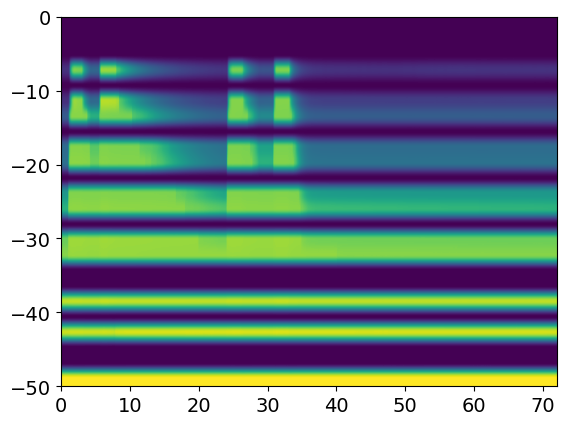

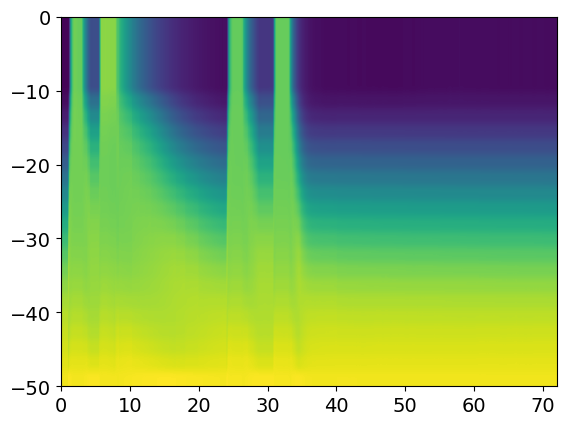

In [10]:
New_Depth=-np.arange(2,50,2)
Sw, Pw, Pf, depth = np.load(r'Saturation_Pw_Pf_depth_Clarisse2.npy',allow_pickle=True)
import numpy as np
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
Sw_new=np.zeros((New_Depth.size,Sw[0].size))
for i in range(depth.size):
    idx=find_nearest(New_Depth,depth[i])
    Sw_new[idx]=Sw[i]
SS=Sw_new.copy()
plt.imshow(Sw_new,aspect='auto',extent=[0,72,-50,0])    
Sw_new[0]=Sw_new[4]
Sw_new[1]=Sw_new[4]
Sw_new[2]=Sw_new[4]
Sw_new[3]=Sw_new[4]
Sw_new[4]=Sw_new[4]

for i in range(25920):
    y = Sw[:,i]
    x = depth
    z = np.polyfit(x, y, 4)
    p = np.poly1d(z)
    j=p(New_Depth)
    Sw_new[:,i]=j

### Saturation extrapolation between - 9 and 0     
Sw_new[0]=Sw_new[4]
Sw_new[1]=Sw_new[4]
Sw_new[2]=Sw_new[4]
Sw_new[3]=Sw_new[4]


#Sw_new[-4]=Sw_new[-5]*1.0001
#Sw_new[-3]=Sw_new[-4]*1.0001
#Sw_new[-2]=Sw_new[-3]*1.0001
#Sw_new[-1]=Sw_new[-2]*1.0001

plt.figure()
plt.imshow(Sw_new,aspect='auto',extent=[0,72,-50,0])    


Time vector corresponding to data (one point every 10 s for 72 hours = 4320 min = 259200 s).

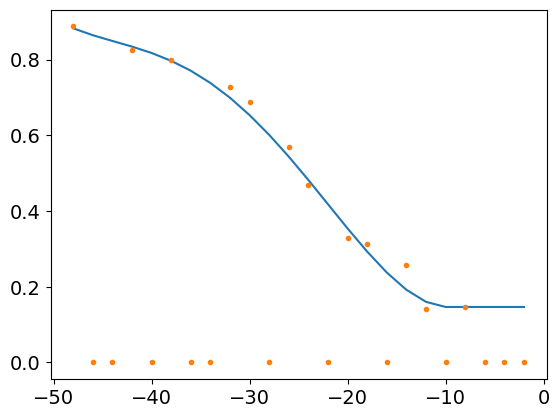

In [11]:
plt.plot(New_Depth,Sw_new[:,0])
y = Sw[:,i]
x = depth
z = np.polyfit(x, y, 2)
p = np.poly1d(z)
j=p(New_Depth)
plt.plot(New_Depth,SS[:,0],'.')


Convert pressures from mbar to kPa.

In [12]:
coeff_corr=0
Pf_depth=27+ coeff_corr     # Depth of Pf measurement
Pz_depth=52#   + coeff_corr    # Depth of Pz measurement
L_sand=58         # Sand width
correct=[]
for i in range(New_Depth.size):
    Sw, Pw, Pf, depth = np.load(r'Saturation_Pw_Pf_depth_Clarisse2.npy',allow_pickle=True)
    Sw=Sw_new
    depth=New_Depth#+ coeff_corr+1
    #depth-=coeff_corr
    Pw = Pw*1e-1 # kPa
    Pf = Pf*1e-1 # kPa
    PzR_depth=abs(depth[i])      # Depth of Pr_R to be recovered
    PiezoRef='Pz'
    # Compute Pw, the recovered pressur at depth z
    if PiezoRef=="Pz":
        print('La référence piezométrique est prise sur le capteur @',Pz_depth,'cm')
        i_piezo = np.argmax(abs(depth))#np.where(depth==np)[0][0] # indice de prof équivalent Pz/Sw, 48 etant le plus proche de 50
        Pw_z=Pw-0.098064*(Pz_depth-PzR_depth) # Calcul de la pression à la profondeur z à partir de Pz
    else:
        print('La référence piezométrique est prise sur le capteur @',Pf_depth,'cm')    
        i_piezo = find_nearest(depth, -Pf_depth) # indice de prof équivalent Pf/Sw
        Pw_z=Pf-0.098064*(Pf_depth-PzR_depth) # Calcul de la pression à la profondeur z à partir de Pf
        Pw_z=Pf-0.098064*(Pf_depth-PzR_depth) # Calcul de la pression à la profondeur z à partir de Pf

    i_piezof =find_nearest(depth, -Pf_depth) #np.where(depth==-Pf_depth)[0][0] # indice de prof équivalent Pf/Sw
    i_piezoR =find_nearest(depth, -PzR_depth) #np.where(depth==-PzR_depth)[0][0] # indice de prof équivalent Pz/Sw
    #print(i_piezoR,PzR_depth)

    #i_piezof = np.where(depth==-Pf_depth)[0][0] # indice de prof équivalent Pf/Sw
    SwPf = Sw[i_piezof,:]
    SwR = Sw[i_piezoR,:]
    # Check hydrostatic values for depth=28cm and depth=54cm
    rho_w = 1.0*1e3            # water density (kg/m3)
    g = 9.806                  # Earth’s gravitational acceleration (m.s^-2)
    z = np.array([Pf_depth,Pz_depth])*1e-2 # depth (m)
    Phydro = rho_w*g*z*1e-3    # computed hydrostatic pressure (kPa)
    # Mineral properties
    K_Qz = 44      #GPa (Barriere et al., GJI 2012) Shear Modulus solid
    G_Qz = 36      #GPa (Barriere et al., GJI 2012) Bulk Modulus solid
    rho_Qz = 2.65  #g/cc (Barriere et al., GJI 2012) density of quartz
    K_Ka = 1.5     #GPa  Bulk Modulus gaz
    G_Ka = 1.4     #GPa  Shear gaz
    rho_Ka = 1.58  #g/cc 1.58
    f_Qz = 1.0     #unitless 1.0

    # Fluid properties
    Kw = 2.5     #GPa 2.3 Barriere 
    rho_w = 1.0  #g/cc 1.0
    Ka = 1e-4    #GPa 1e-4
    rho_a = 1e-3 #g/cc 1e-3

    # Rock matrix properties
    phi = 0.4 #Porosity - measured (Barriere et al., GJI 2012)
    phi_0=0.38
    C0 = 6      #Coordination number in the high stress limit - Landes Sand (Barriere et al., GJI 2012)
    R = 2/5     #Walton friction parameter (Barriere et al., GJI 2012)
    P0 = 22     #Critical pressure for modified Walton model (MPa) - (Barriere et al., GJI 2012)
    Swr = 0.1  #Residual water saturation (to confirm with Thomas)
    Ks = HillAvr(K_Qz, f_Qz, K_Ka)        #GPa
    Gs = HillAvr(G_Qz, f_Qz, G_Ka)        #GPa
    rho_s = rho_Qz*f_Qz + (1-f_Qz)*rho_Ka #g/cc
    rho_f = SwR*rho_w + (1-SwR)*rho_a  #g/cc (fluid density at piezometer level) # Control Vs
    rho_f_full = Sw*rho_w + (1-Sw)*rho_a #g/cc
    Kf = fluidWood(SwR, Kw, Ka)         #GPa
    # Bulk density
    rho_sat = rho_s*(1-phi) + rho_f_full[i_piezof,:]*phi        #g/cc (fluid density at piezometer level)
    rho_satR = rho_s*(1-phi) + rho_f_full[i_piezoR,:]*phi        #g/cc (fluid density at piezometer level)
    rho_sat_full = rho_s*(1-phi) + rho_f_full*phi #g/cc 
    P=np.zeros([len(depth), Sw[0].size]) # matrice utilisée pour la pression de confirnement (overburden stress)
    prod_rhoDepth_min = np.zeros(np.shape(Sw))
    for i_depth in range(New_Depth.size):
        if i_depth == 0 :
            prod_rhoDepth_min[i_depth,:] = rho_sat_full[i_depth,:]*1e3*abs(depth[i_depth]-0)*1e-2  
            #print(depth[i_depth])
            P[i_depth,:]= prod_rhoDepth_min[i_depth,:]*g*1e-6
        else :
            prod_rhoDepth_min[i_depth,:] = rho_sat_full[i_depth,:]*1e3*abs(depth[i_depth]-depth[i_depth-1])*1e-2  #  * dz
            #prod_rhoDepth_min[i_depth,:] = rho_sat_full[i_depth,:]*1e3*abs(depth[i_depth])*1e-2  #  * dz

            P[i_depth,:]=np.sum(prod_rhoDepth_min[0:i_depth,:],axis=0)*g*1e-6 + P[0,:]

    # Effective pressure
    #-- Test Peff = P - Pf
    Peff = P[i_piezof,:] - Pf*1e-3  # effective pressure (MPa) Terzaghi @ 27cm (Peff=sigma-Pf)
    Peff2 = P[i_piezoR,:]  -__Swe(Sw[i_depth],Swr)*Pw_z*1e-3# effective pressure (MPa) used for the simple fluid substitution
    Peff_z = P[i_piezoR,:] - Pw_z*1e-3  # effective pressure (MPa) recovered at depth z # Il faut casser cette valeur par 3 pour tendre
    #Peff_z=(1-phi)*(rho_Qz-np.sum(Sw_new[0:i_depth])*1)*g*(abs(depth[i_depth]*10**-2))*1e-3
    #Peff_z=(1-phi)*(rho_Qz-np.sum(Sw_new[0:i_depth],0)/i_depth*1)*g*(abs(depth[i_depth]*10**-2))*1e-3

    # Vers des Vs acceptable.
    # Drained properties
    ### içi.
    Kdr, Gdr = Walton_modified(Ks, Gs, Peff, P0, phi=phi_0, C0=C0, R=R); # Biot-Gassman + Walton avec Pf
    Kdr2, Gdr2 = Walton_modified(Ks, Gs, Peff2, P0, phi=phi_0, C0=C0, R=R) # Biot Gassman substitution de fluide sans Pf
    Kdrz, Gdrz = Walton_modified(Ks, Gs, Peff_z, P0, phi=phi_0, C0=C0, R=R)# Biot-Gassman + Walton avec Pf recovered @ z
    # Saturated properties
    Ksat = isoGassmann(Kdr, Gdr, Ks, Kf, phi)
    Vp_sat = Vp_from_K_G(Ksat, Gdr, rho_sat)
    Vs_sat = Vs_from_G(Gdr, rho_sat)
    Ksat2 = isoGassmann(Kdr2[len(Kdr2)-10], Gdr2[len(Kdr2)-10], Ks, Kf, phi)
    Vp_sat2= Vp_from_K_G(Ksat2, Gdr2, rho_satR)
    Vs_sat2 = Vs_from_G(Gdr2, rho_satR)
    Ksatz = isoGassmann(Kdrz[len(Kdrz)-10], Gdrz[len(Kdrz)-10], Ks, Kf, phi) ### Pourquoi - 10? -- On s'en fou
    Vp_satz= Vp_from_K_G(Ksatz, Gdrz, rho_satR)
    Vs_satz = Vs_from_G(Gdrz, rho_satR)
    # Reference velocities (same as Thomas, avg of velocities between 2300 and 3000 min)
    t_ref1 = int(2300*60/10)
    t_ref2 = int(3000*60/10)
    Vp_ref = np.nanmean(Vp_sat[t_ref1:t_ref2]); #print('Vp_ref = {:.1f} m/s'.format(Vp_ref*1e3))
    Vs_ref = np.nanmean(Vs_sat[t_ref1:t_ref2]); #print('Vs_ref = {:.1f} m/s'.format(Vs_ref*1e3))
    Vp_ref2 = np.nanmean(Vp_sat2[t_ref1:t_ref2]); #print('Vp_ref2 = {:.1f} m/s'.format(Vp_ref2*1e3))
    Vs_ref2 = np.nanmean(Vs_sat2[t_ref1:t_ref2]); print('Vs_ref2 = {:.1f} m/s'.format(Vs_ref2*1e3))
    Vp_refz = np.nanmean(Vp_satz[t_ref1:t_ref2]); #print('Vp_refz = {:.1f} m/s'.format(Vp_refz*1e3))
    Vs_refz = np.nanmean(Vs_satz[t_ref1:t_ref2]); print('Vs_refz = {:.1f} m/s'.format(Vs_refz*1e3))
    #Biot-Gassman
    Kfr=0.02 # Frame modulus
    Gfr=0.0154 # shear frame modulus
    KsatB= isoGassmann(Kfr, Gfr, Ks, Kf, phi)
    Vp_satB=Vp_from_K_G(KsatB,Gfr,rho_satR)
    Vs_satB = Vs_from_G(Gfr, rho_satR)
    Vp_refB = np.mean(Vp_satB[t_ref1:t_ref2]); #print('Vp_refB = {:.1f} m/s'.format(Vp_refB*1e3))
    Vs_refB = np.mean(Vs_satB[t_ref1:t_ref2]); #print('Vs_refB = {:.1f} m/s'.format(Vs_refB*1e3))
    #np.save(rf'C:\Hydro_modele\dv_compute\roflTest_Modeling_petro_{phi}1_cmInterp_SwPf_Phi_0v2_{PzR_depth}_{PiezoRef}__piezo_depth_{Pz_depth}_add_BG',[Vp_sat,Vs_sat,Vp_sat2,Vs_sat2,Vp_satz,Vs_satz,Vp_refB,Vs_refB,Vs_satB,rho_sat_full,Peff_z])

La référence piezométrique est prise sur le capteur @ 52 cm
Vs_ref2 = 71.5 m/s
Vs_refz = 73.8 m/s
La référence piezométrique est prise sur le capteur @ 52 cm
Vs_ref2 = 72.2 m/s
Vs_refz = 74.3 m/s
La référence piezométrique est prise sur le capteur @ 52 cm
Vs_ref2 = 72.9 m/s
Vs_refz = 74.9 m/s
La référence piezométrique est prise sur le capteur @ 52 cm
Vs_ref2 = 73.6 m/s
Vs_refz = 75.4 m/s
La référence piezométrique est prise sur le capteur @ 52 cm
Vs_ref2 = 74.3 m/s
Vs_refz = 75.9 m/s
La référence piezométrique est prise sur le capteur @ 52 cm
Vs_ref2 = 74.7 m/s
Vs_refz = 76.3 m/s
La référence piezométrique est prise sur le capteur @ 52 cm
Vs_ref2 = 75.1 m/s
Vs_refz = 76.4 m/s
La référence piezométrique est prise sur le capteur @ 52 cm
Vs_ref2 = 75.3 m/s
Vs_refz = 76.5 m/s
La référence piezométrique est prise sur le capteur @ 52 cm
Vs_ref2 = 75.4 m/s
Vs_refz = 76.5 m/s
La référence piezométrique est prise sur le capteur @ 52 cm
Vs_ref2 = 75.5 m/s
Vs_refz = 76.4 m/s
La référence piezomé

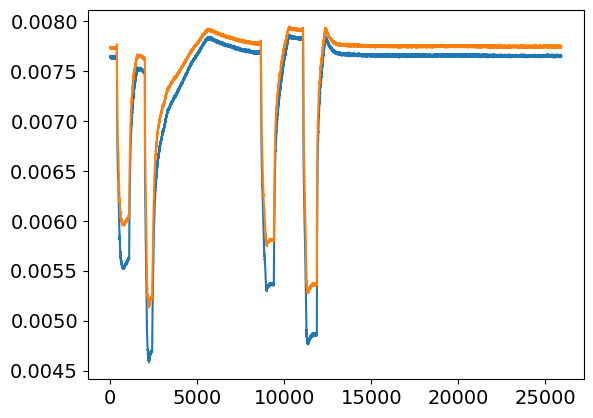

In [13]:
plt.plot(Peff_z)
plt.plot(Peff2)

In [49]:
Peff_z

array([0.00745279, 0.00745016, 0.00744364, ..., 0.0074652 , 0.00746271,
       0.00744612])

24


C:\Users\tgaubert001\.conda\envs\Acquisition\lib\site-packages\ipykernel_launcher.py:200: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


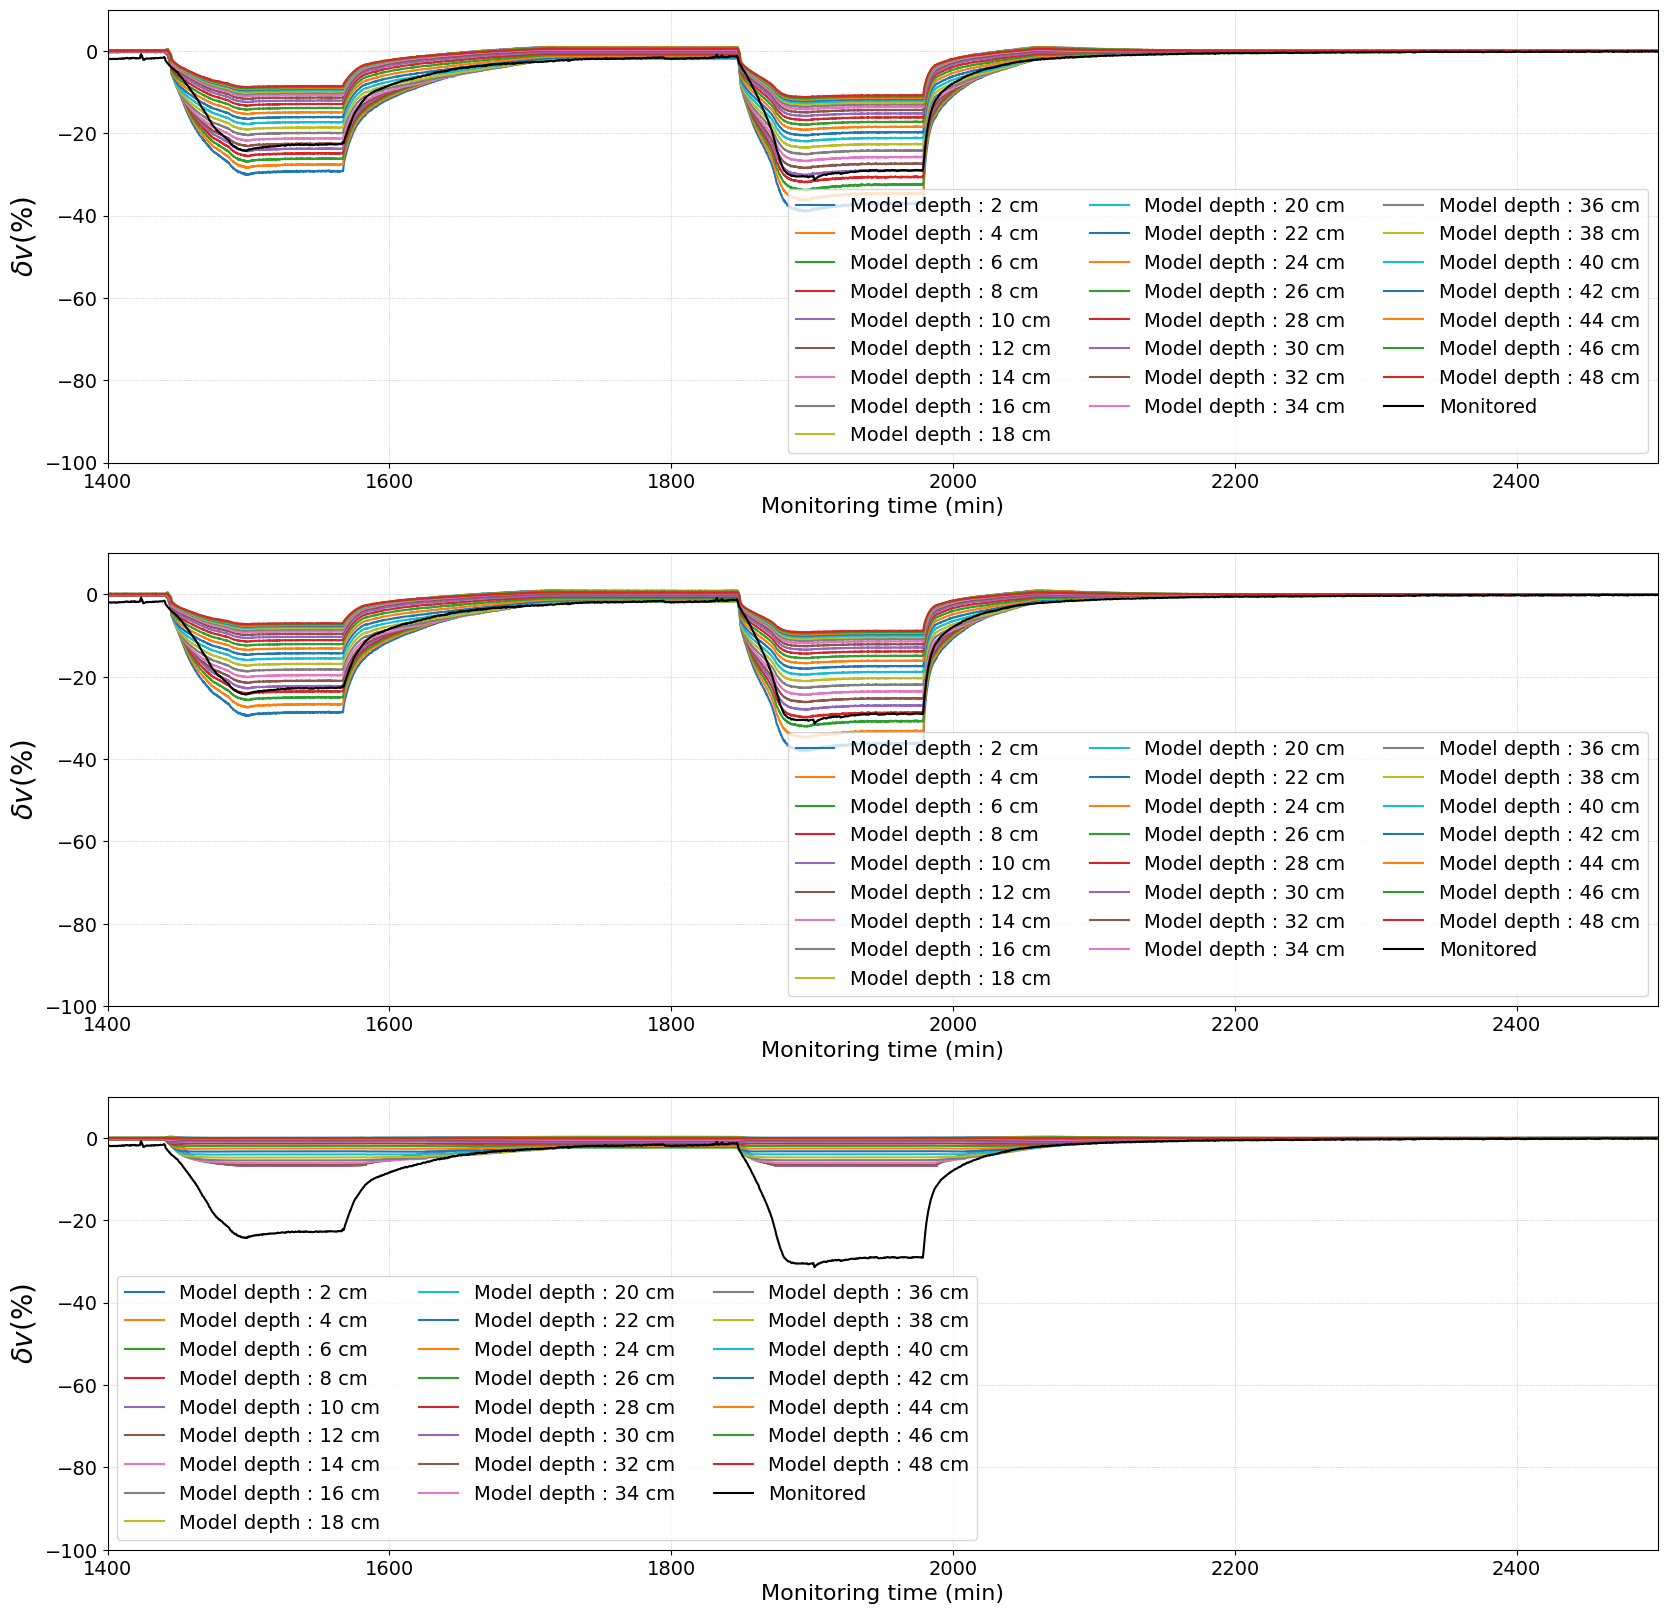

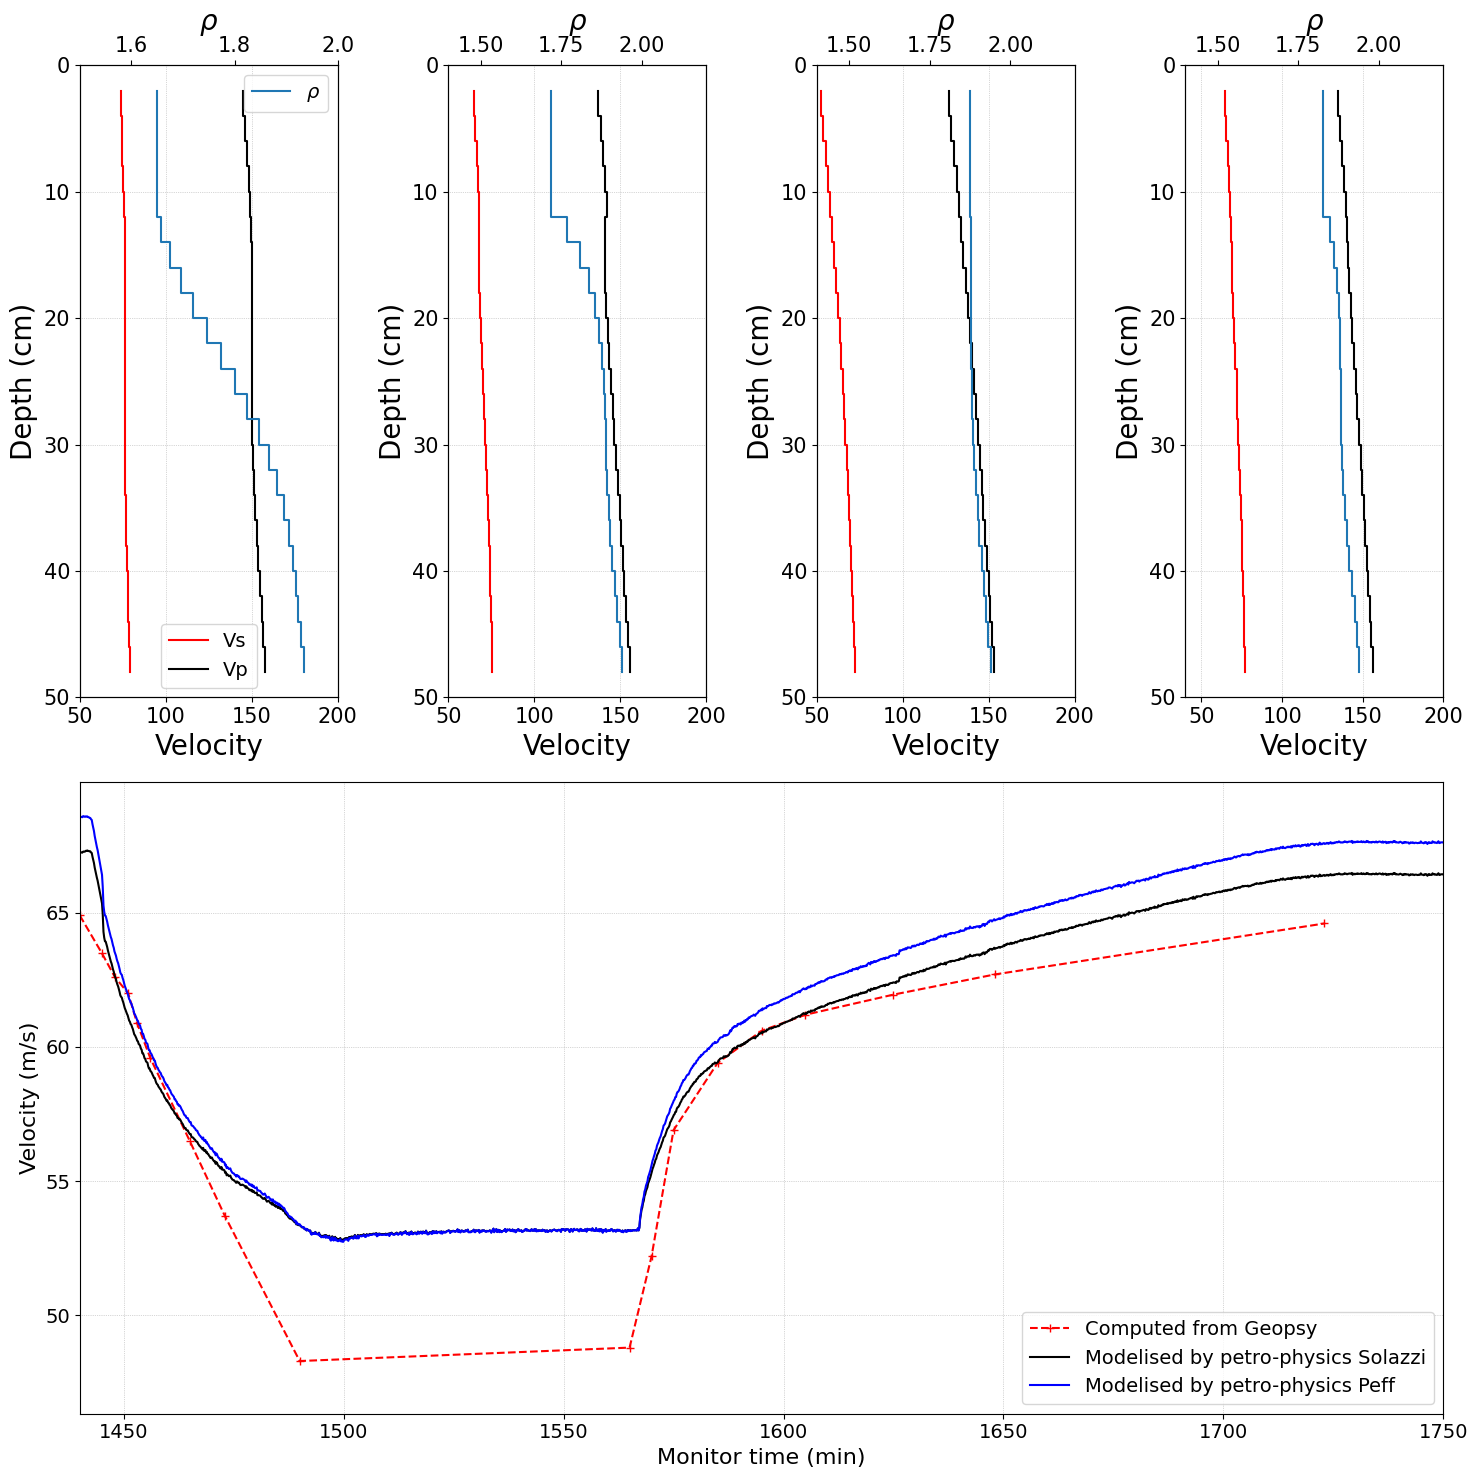

In [14]:
os.chdir('C:\Hydro_modele\Olivia')
Vp=[]
Vs=[]
Vp_ref2=[]
Vs_ref2=[]
Vp_refz=[]
Vs_refz=[]
t_ref1 = int(2300*60/10)
t_ref2 = int(3000*60/10)
Vp0=[]
Vs0=[]
Vp1=[]
Vs1=[]
Vp2=[]
Vs2=[]
Vb=[]
Vbref=[]
corr=+0
Sw, Pw, Pf, depth = np.load(r'Saturation_Pw_Pf_depth_Clarisse2.npy',allow_pickle=True)
Peff=[]
Rho=[]
for i in range(New_Depth.size):
    #data=np.load(rf'C:\Hydro_modele\dv_compute\{abs(depth[i])+corr}_Pz.npy')
    PzR_depth=abs(New_Depth[i])
    #data=np.load(rf'C:\Hydro_modele\dv_compute\Test_Modeling_petro_{phi}1_cmInterp_SwPf_Phi_0v2_{PzR_depth}_{PiezoRef}__piezo_depth_{Pz_depth}_add_BG.npy')
    data=np.load(rf'C:\Hydro_modele\dv_compute\Test_Modeling_petro_{phi}1_cmInterp_SwPf_Phi_0v2_{PzR_depth}_{PiezoRef}__piezo_depth_{Pz_depth}_add_BG.npy',allow_pickle=True)
    #data=np.load(rf'C:\Hydro_modele\dv_compute\Modeling_petro_{phi}1_cmInterp_SwPf_Phi_0v2_{PzR_depth}_{PiezoRef}_add_BG.npy',allow_pickle=True)
    #1_cmInterp_SwPf_Phi_0v2_{PzR_depth}_{PiezoRef}_add_BG.npy',allow_pickle=True)
    Vp.append(data[0])
    Vs.append(data[1])
    Vp_ref2.append(data[2])
    Vs_ref2.append(data[3])
    Vp_refz.append(data[4])
    Vs_refz.append(data[5])
    Vb.append(data[8])
    Vp0.append(np.nanmean(data[0][t_ref1:t_ref2]))
    Vs0.append(np.nanmean(data[1][t_ref1:t_ref2]))
    Vp1.append(np.nanmean(data[2][t_ref1:t_ref2]))
    Vs1.append(np.nanmean(data[3][t_ref1:t_ref2]))
    Vp2.append(np.nanmean(data[4][t_ref1:t_ref2]))
    Vs2.append(np.nanmean(data[5][t_ref1:t_ref2]))
    Vbref.append(np.nanmean(data[8][t_ref1:t_ref2]))
    Peff.append(data[-1])
    Rho.append(data[-2])
print(len(Vs0))
dvp=[]
dvs=[]
dvp1=[]
dvs1=[]
dvp2=[]
dvs2=[]
dvGBW=[]
for i in range(New_Depth.size):
    dvp.append((Vp[i]-Vp0[i])/Vp0[i]*1e2)
    dvs.append((Vs[i]-Vs0[i])/Vs0[i]*1e2)
    dvp1.append((Vp_ref2[i]-Vp1[i])/Vp1[i]*1e2)
    dvs1.append((Vs_ref2[i]-Vs1[i])/Vs1[i]*1e2)
    dvp2.append((Vp_refz[i]-Vp2[i])/Vp2[i]*1e2)
    dvs2.append((Vs_refz[i]-Vs2[i])/Vs2[i]*1e2)
    dvGBW.append((Vb[i]-Vbref[i])/Vb[i]*1e2)
dvR=np.load('G:\dv_median.npy')
tT=np.linspace(0,72*60,dvR.size)
t = tT
data=[]
fig, axs = plt.subplots(3,1,figsize=(20,20), facecolor='w', edgecolor='k')
axs=axs.ravel()
ax=axs[0]
for i in range(0,New_Depth.size):#depth.size-1):
    ax.plot(tT,dvs2[i],label=f'Model depth : {abs(New_Depth[i])} cm')
    data.append(dvs2[i])
ax.plot(tT,dvR,'black',label='Monitored')
ax.set_xlim(1400,2500)
ax.legend(ncol=3)
ax.grid()
ax.set(xlabel='Monitoring time (min)', xlim=[1400,2500],
       ylabel=r'$\delta v$ (%)', ylim=[-100,10])
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.set_ylabel(r'$\delta v (\%)$',fontsize=20)
ax=axs[1]
data1=[]
for i in range(0,New_Depth.size):#depth.size-1):
    ax.plot(tT,dvs1[i],label=f'Model depth : {abs(New_Depth[i])} cm')
    data1.append(dvs1[i])
ax.plot(tT,dvR,'black',label='Monitored')
ax.set_xlim(1400,2500)
ax.legend(ncol=3)
ax.grid()
ax.set(xlabel='Monitoring time (min)', xlim=[1400,2500],
       ylabel=r'$\delta v$ (%)', ylim=[-100,10])
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.set_ylabel(r'$\delta v (\%)$',fontsize=20)


ax=axs[2]

for i in range(0,New_Depth.size):#depth.size-1):
    ax.plot(tT,dvGBW[i],label=f'Model depth : {abs(New_Depth[i])} cm')
#    data.append(dvs2[i])
ax.plot(tT,dvR,'black',label='Monitored')
ax.set_xlim(1400,2500)
ax.legend(ncol=3)
ax.grid()
ax.set(xlabel='Monitoring time (min)', xlim=[1400,2500],
       ylabel=r'$\delta v$ (%)', ylim=[-100,10])
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.set_ylabel(r'$\delta v (\%)$',fontsize=20)
#plt.savefig('F:\Fig_to_make/depth_model.pdf',format='pdf',bbox_inches='tight',dpi=300)
#plt.savefig('F:\Fig_to_make/depth_model.jpg',format='jpg',bbox_inches='tight',dpi=300)
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
fig = plt.figure(figsize=(15,15),constrained_layout=True)
gs = gridspec.GridSpec(4, 4)
ax1 = plt.subplot(gs[0:2,0])
ax2 = plt.subplot(gs[0:2, 1])
ax3 = plt.subplot(gs[0:2, 2])
ax4 = plt.subplot(gs[0:2, 3])
ax5 = plt.subplot(gs[2::, :])
dvP,dvS,dvRho,prof=__function_staircase(-New_Depth,Vp_refz,Vs_refz,Rho[0],times[0]*6)
ax1.plot(dvS*1000,prof,'r',label='Vs')
ax1.plot(dvP*1000,prof,'k',label='Vp')
ax1.set_ylim(50,0)
ax11 = ax1.twiny()
ax11.plot(dvRho,prof,label=r'$\rho$')
ax11.set_xlim(1.5,2)
ax11.set_xlabel(r'$\rho$',fontsize=20)
ax1.set_xlabel('Velocity',fontsize=20)
ax1.grid()
ax1.set_ylabel('Depth (cm)',fontsize = 20)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax11.tick_params(axis='both', which='major', labelsize=15)
ax1.set_xlim(50,200)
ax11.legend()
ax1.legend()



dvP,dvS,dvRho,prof=__function_staircase(-New_Depth,Vp_refz,Vs_refz,Rho[0],times[4]*6)
ax2.plot(dvS*1000,prof,'r')
ax2.plot(dvP*1000,prof,'k')
ax2.set_ylim(50,0)
ax22 = ax2.twiny()
ax22.plot(dvRho,prof)
ax22.set_xlim(1.4,2.2)
ax22.set_xlabel(r'$\rho$',fontsize=20)
ax2.set_xlabel('Velocity',fontsize=20)
ax2.grid()
ax2.set_ylabel('Depth (cm)',fontsize = 20)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax22.tick_params(axis='both', which='major', labelsize=15)
ax2.set_xlim(50,200)



dvP,dvS,dvRho,prof=__function_staircase(-New_Depth,Vp_refz,Vs_refz,Rho[0],1530*6)
ax3.plot(dvS*1000,prof,'r')
ax3.plot(dvP*1000,prof,'k')
ax3.set_ylim(50,0)
ax33 = ax3.twiny()
ax33.plot(dvRho,prof)
ax33.set_xlim(1.4,2.2)
ax33.set_xlabel(r'$\rho$',fontsize=20)
ax3.set_xlabel('Velocity',fontsize=20)
ax3.grid()
ax3.set_ylabel('Depth (cm)',fontsize = 20)
ax3.tick_params(axis='both', which='major', labelsize=15)
ax33.tick_params(axis='both', which='major', labelsize=15)
ax3.set_xlim(50,200)

dvP,dvS,dvRho,prof=__function_staircase(-New_Depth,Vp_refz,Vs_refz,Rho[0],times[13]*6)
ax4.plot(dvS*1000,prof,'r')
ax4.plot(dvP*1000,prof,'k')
ax4.set_ylim(50,0)
ax44 = ax4.twiny()
ax44.plot(dvRho,prof)
ax44.set_xlim(1.4,2.2)
ax44.set_xlabel(r'$\rho$',fontsize=20)
ax4.set_xlabel('Velocity',fontsize=20)
ax4.grid()
ax4.set_ylabel('Depth (cm)',fontsize = 20)
ax4.tick_params(axis='both', which='major', labelsize=15)
ax44.tick_params(axis='both', which='major', labelsize=15)
ax4.set_xlim(40,200)


tT=np.linspace(0,72*60,Vs_refz[0].size)
ax5.plot(times,v,'+r--', label='Computed from Geopsy')
ax5.plot(tT,0.9*1000*Vs_ref2[5],'k',label='Modelised by petro-physics Solazzi')
ax5.plot(tT,0.9*1000*Vs_refz[5],'b',label='Modelised by petro-physics Peff')


ax5.set_xlim(1440,1750)
ax5.legend()
ax5.grid()
ax5.set_ylabel('Velocity (m/s)')
ax5.set_xlabel('Monitor time (min)')

fig.tight_layout()


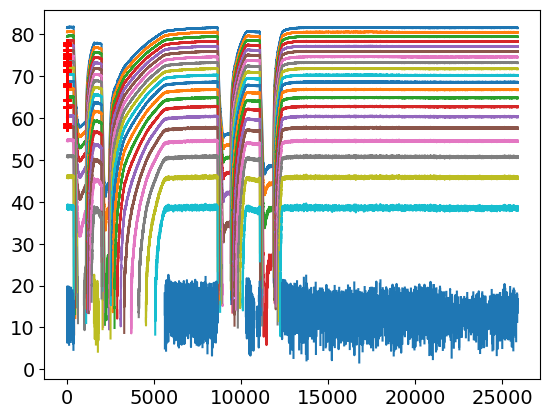

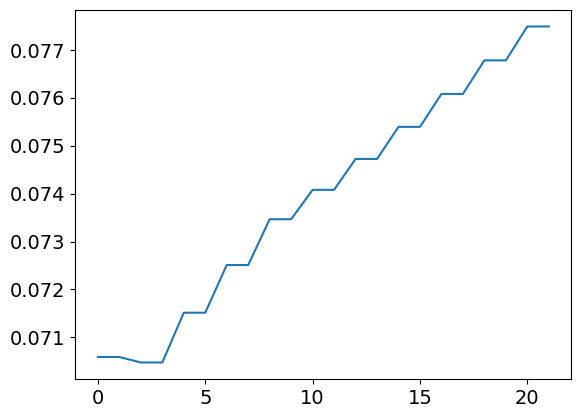

In [338]:
plt.plot(dvS)

In [274]:
f1=200
f2=300
Kernel=np.load(rf'C:\Hydro_modele\Kernel\Frequence\{f1}_{f2}\Kernel_{0}.npy')


In [353]:
New_depth.size

NameError: name 'New_depth' is not defined

(24, 25920)
(24, 25920)
(24, 25920)
(24, 25920)
(24, 25920)
(24, 25920)
(24, 25920)
(24, 25920)


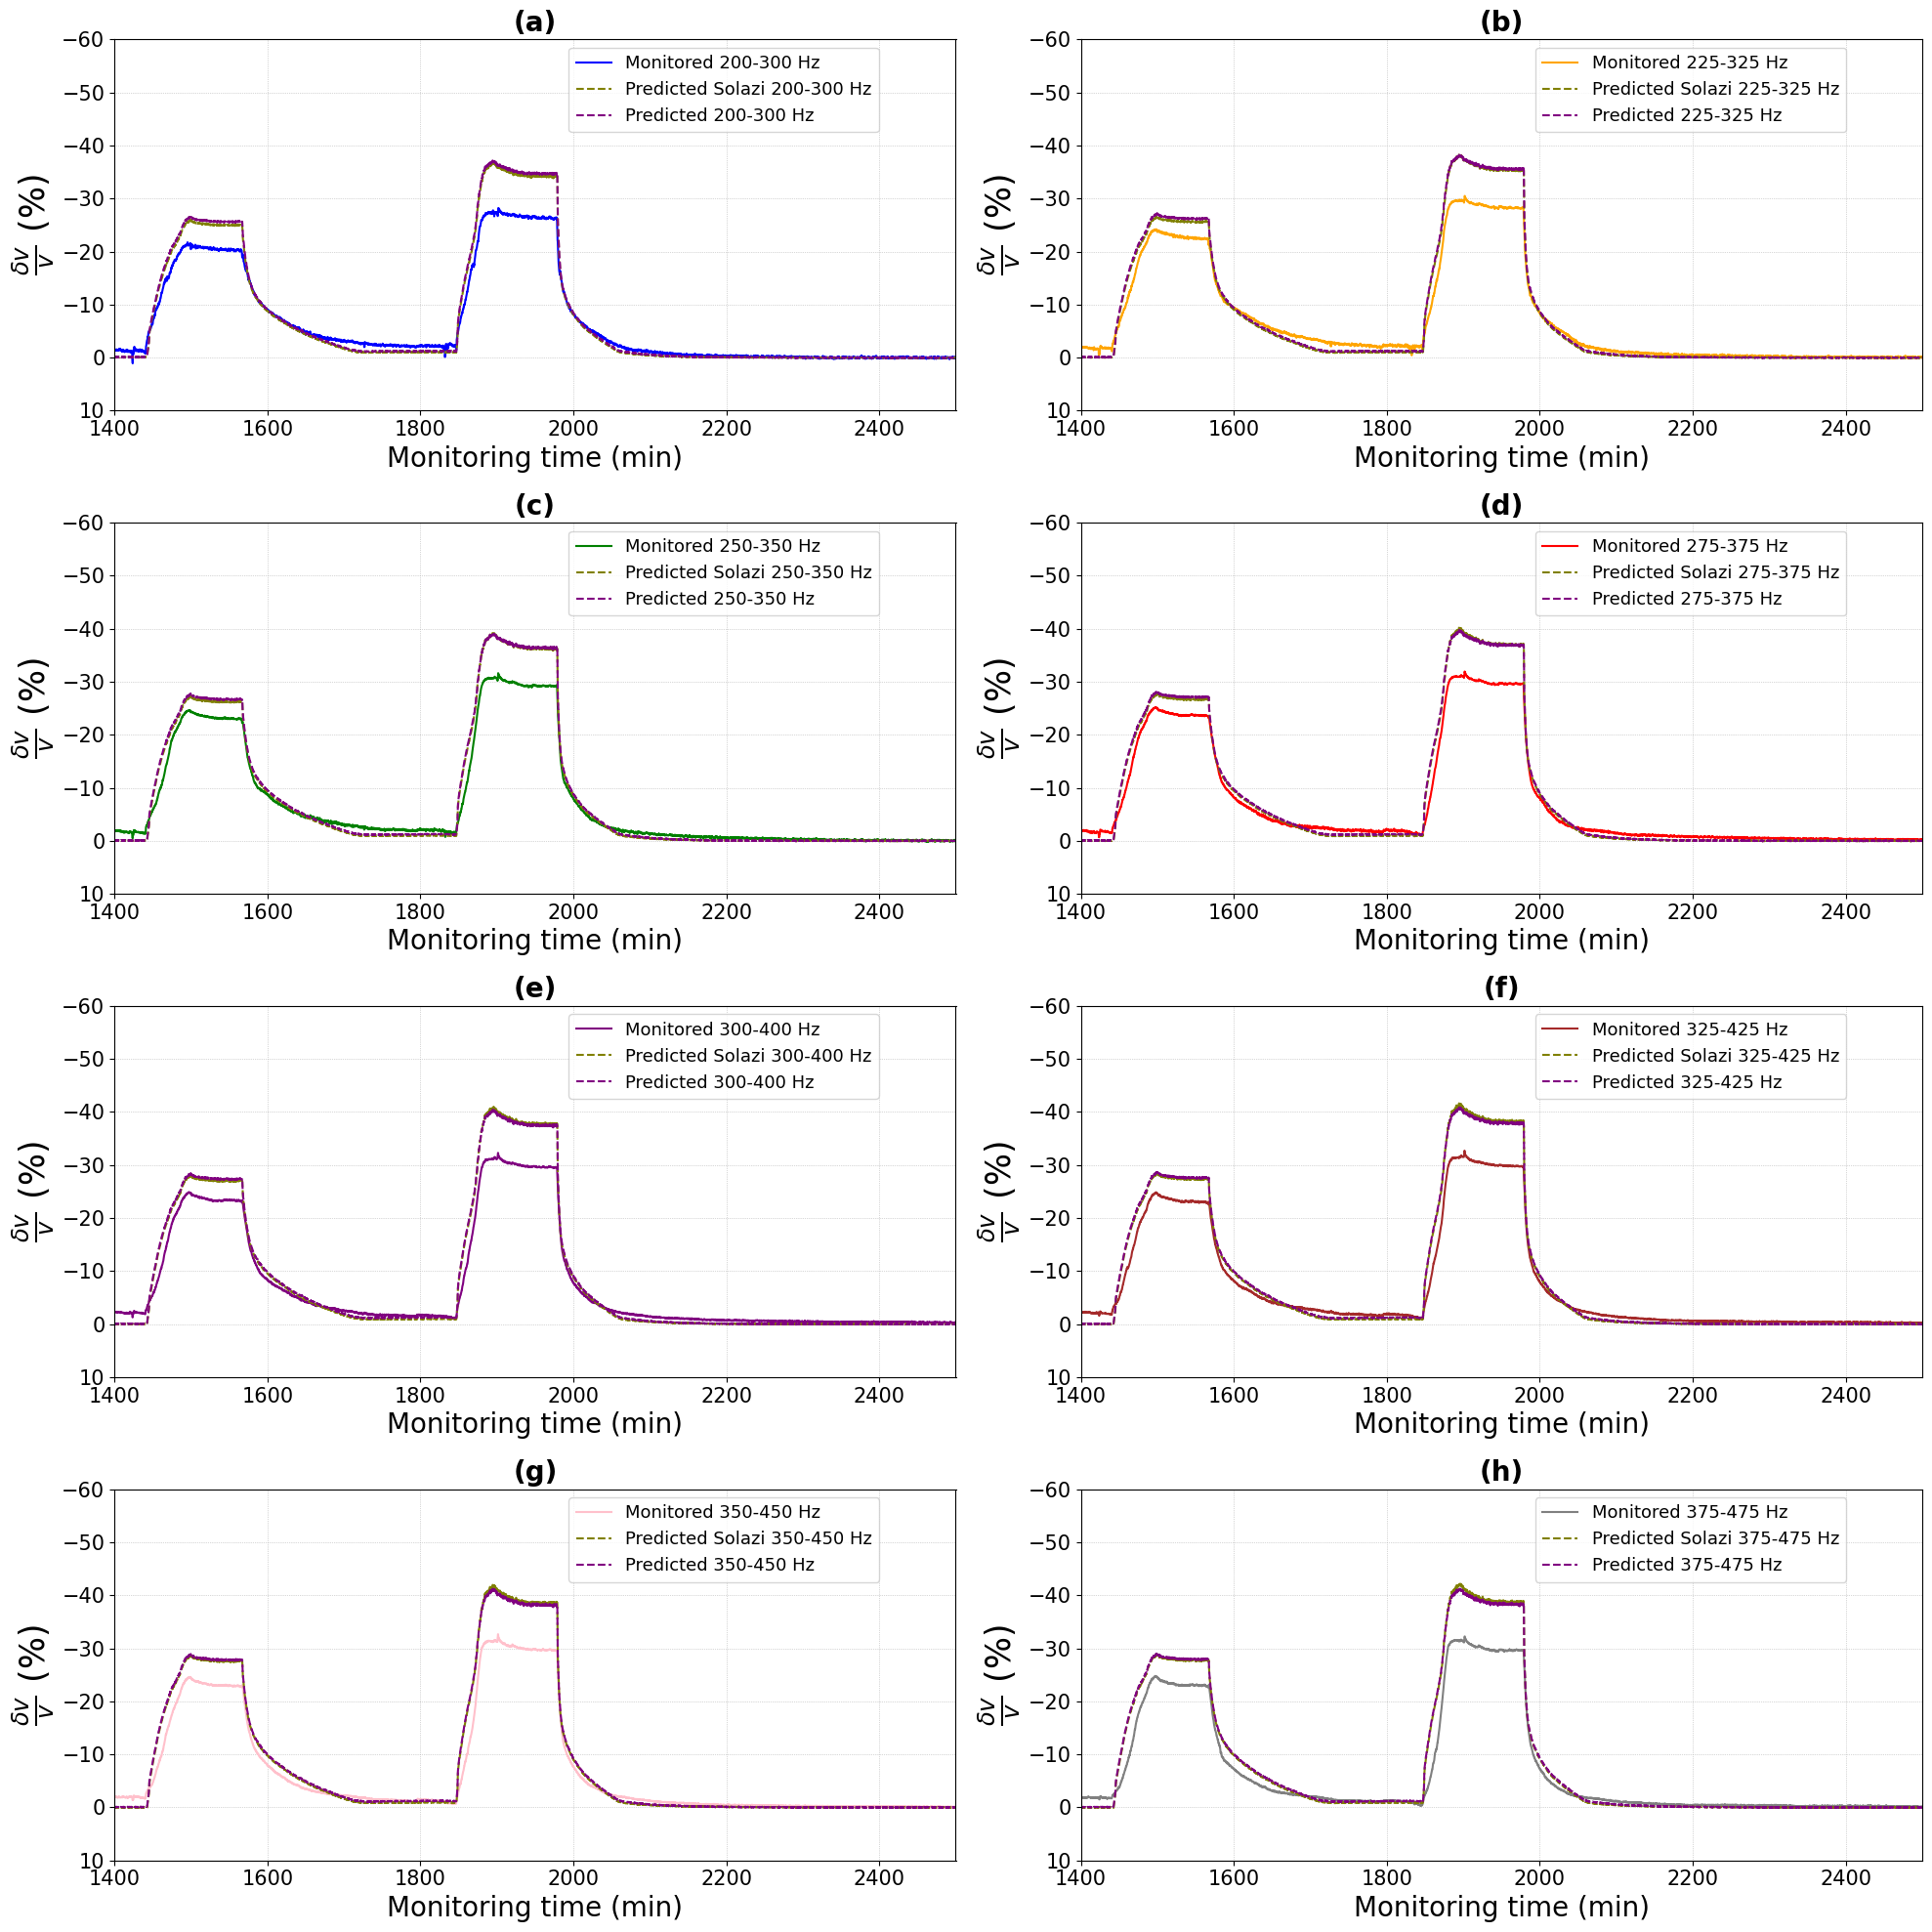

In [92]:
#dvff=np.load('G:/Final_frequency_dv.npy')
dvff=np.load('G:/Final_frequency_dv_15_trace.npy')
D=np.asarray(dvff)
DV=np.asarray(dvff)
from scipy import signal
col=np.asarray(['blue','orange','green','red','purple','brown','pink','grey'])
C=np.asarray(['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)'])
fig, axs = plt.subplots(4,2,figsize=(20,20), facecolor='w', edgecolor='k')
axs=axs.ravel()
dvf1=200
dvf2=300
dvwet=[]
DV=[]
dvdry=[]
dvf1=200
dvf2=300
DVSOLAZI=[]
DVPEFF=[]
for i in range(8):
    ax=axs[i]
    dv=dvff[i]#[8000::]
    t=tT#[8000::]
    ax.plot(t,dv,color=col[i],label=f'Monitored {dvf1}-{dvf2} Hz')#
    #Kernel=np.load(rf'C:\Hydro_modele\Kernel\Frequence\{dvf1}_{dvf2}\Kernel_{0}.npy')
    KernelPeff=np.load(rf'C:\Hydro_modele\Kernel\Frequence\Peff_52_{dvf1}_{dvf2}_Kernel_end.npy',allow_pickle=True)
    idxPeff=np.load(rf'C:\Hydro_modele\Kernel\Frequence\Peff_52_{dvf1}_{dvf2}_indice_end.npy',allow_pickle=True)
    KernelSol=np.load(rf'C:\Hydro_modele\Kernel\Frequence\Peff_50_{dvf1}_{dvf2}_Kernel_end.npy',allow_pickle=True)
    idxSol=np.load(rf'C:\Hydro_modele\Kernel\Frequence\Peff_50_{dvf1}_{dvf2}_indice_end.npy',allow_pickle=True)


    data=[]
    data2=[]
    for j in range(0,New_Depth.size):#depth.size-1):
        data.append(dvs2[j])
        data2.append(dvs1[j])
    print(np.shape(data))
    dvv=[]
    dvvsolazi=[]
    data=np.asarray(data)
    data2=np.asarray(data2)
    dvvPeff=[]
    for k in range(25920):
        index_kernelP=(find_nearest(idxPeff,k))
        index_kernelS=(find_nearest(idxSol,k))
        #if  np.trapz((Kernel[index_kernel][0:24]))!=1:
        #    Kernel[index_kernel][0:24]=Kernel[index_kernel][0:24]*(1/np.trapz((Kernel[index_kernel][0:24])))
        dvvPeff.append(np.trapz((KernelPeff[index_kernelP][0:24])*data[:,k]))
        dvvsolazi.append(np.trapz((KernelSol[index_kernelS][0:24])*data2[:,k]))
    ax.plot(tT,dvvsolazi,'--',color='olive',label=f'Predicted Solazi {dvf1}-{dvf1+100} Hz')
    ax.plot(tT,dvvPeff,'--',color='purple',label=f'Predicted {dvf1}-{dvf1+100} Hz')
    ax.set_xlim(1400,2500)
    ax.legend(fontsize=13,loc=(0.54,0.75))
    ax.grid()
    ax.set(xlabel='Monitoring time (min)', xlim=[1400,2500],
           ylabel=r'$\delta v$ (%)', ylim=[-50,10])
    ax.set_xlabel('Monitoring time (min)',fontsize=20)
    ax.set_ylabel(r'$\frac{\delta v}{v}$ (%)',fontsize=25)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=15)
    ax.set_title(C[i],fontsize=20,y=1,fontweight="bold")
    ax.set_ylim(10,-60)
    DVPEFF.append(dvvPeff)
    DVSOLAZI.append(dvvsolazi)
    dvf1+=25
    dvf2+=25
fig.tight_layout()
#plt.savefig('F:\Fig_to_make/ModelKernelfrequency_color_interp_Sw_ref.pdf',format='pdf',bbox_inches='tight',dpi=300)
#plt.savefig('F:\Fig_to_make/ModelKernelfrequency_color_interp_Sw_ref.jpg',format='jpg',bbox_inches='tight',dpi=300)

NameError: name 'im0' is not defined

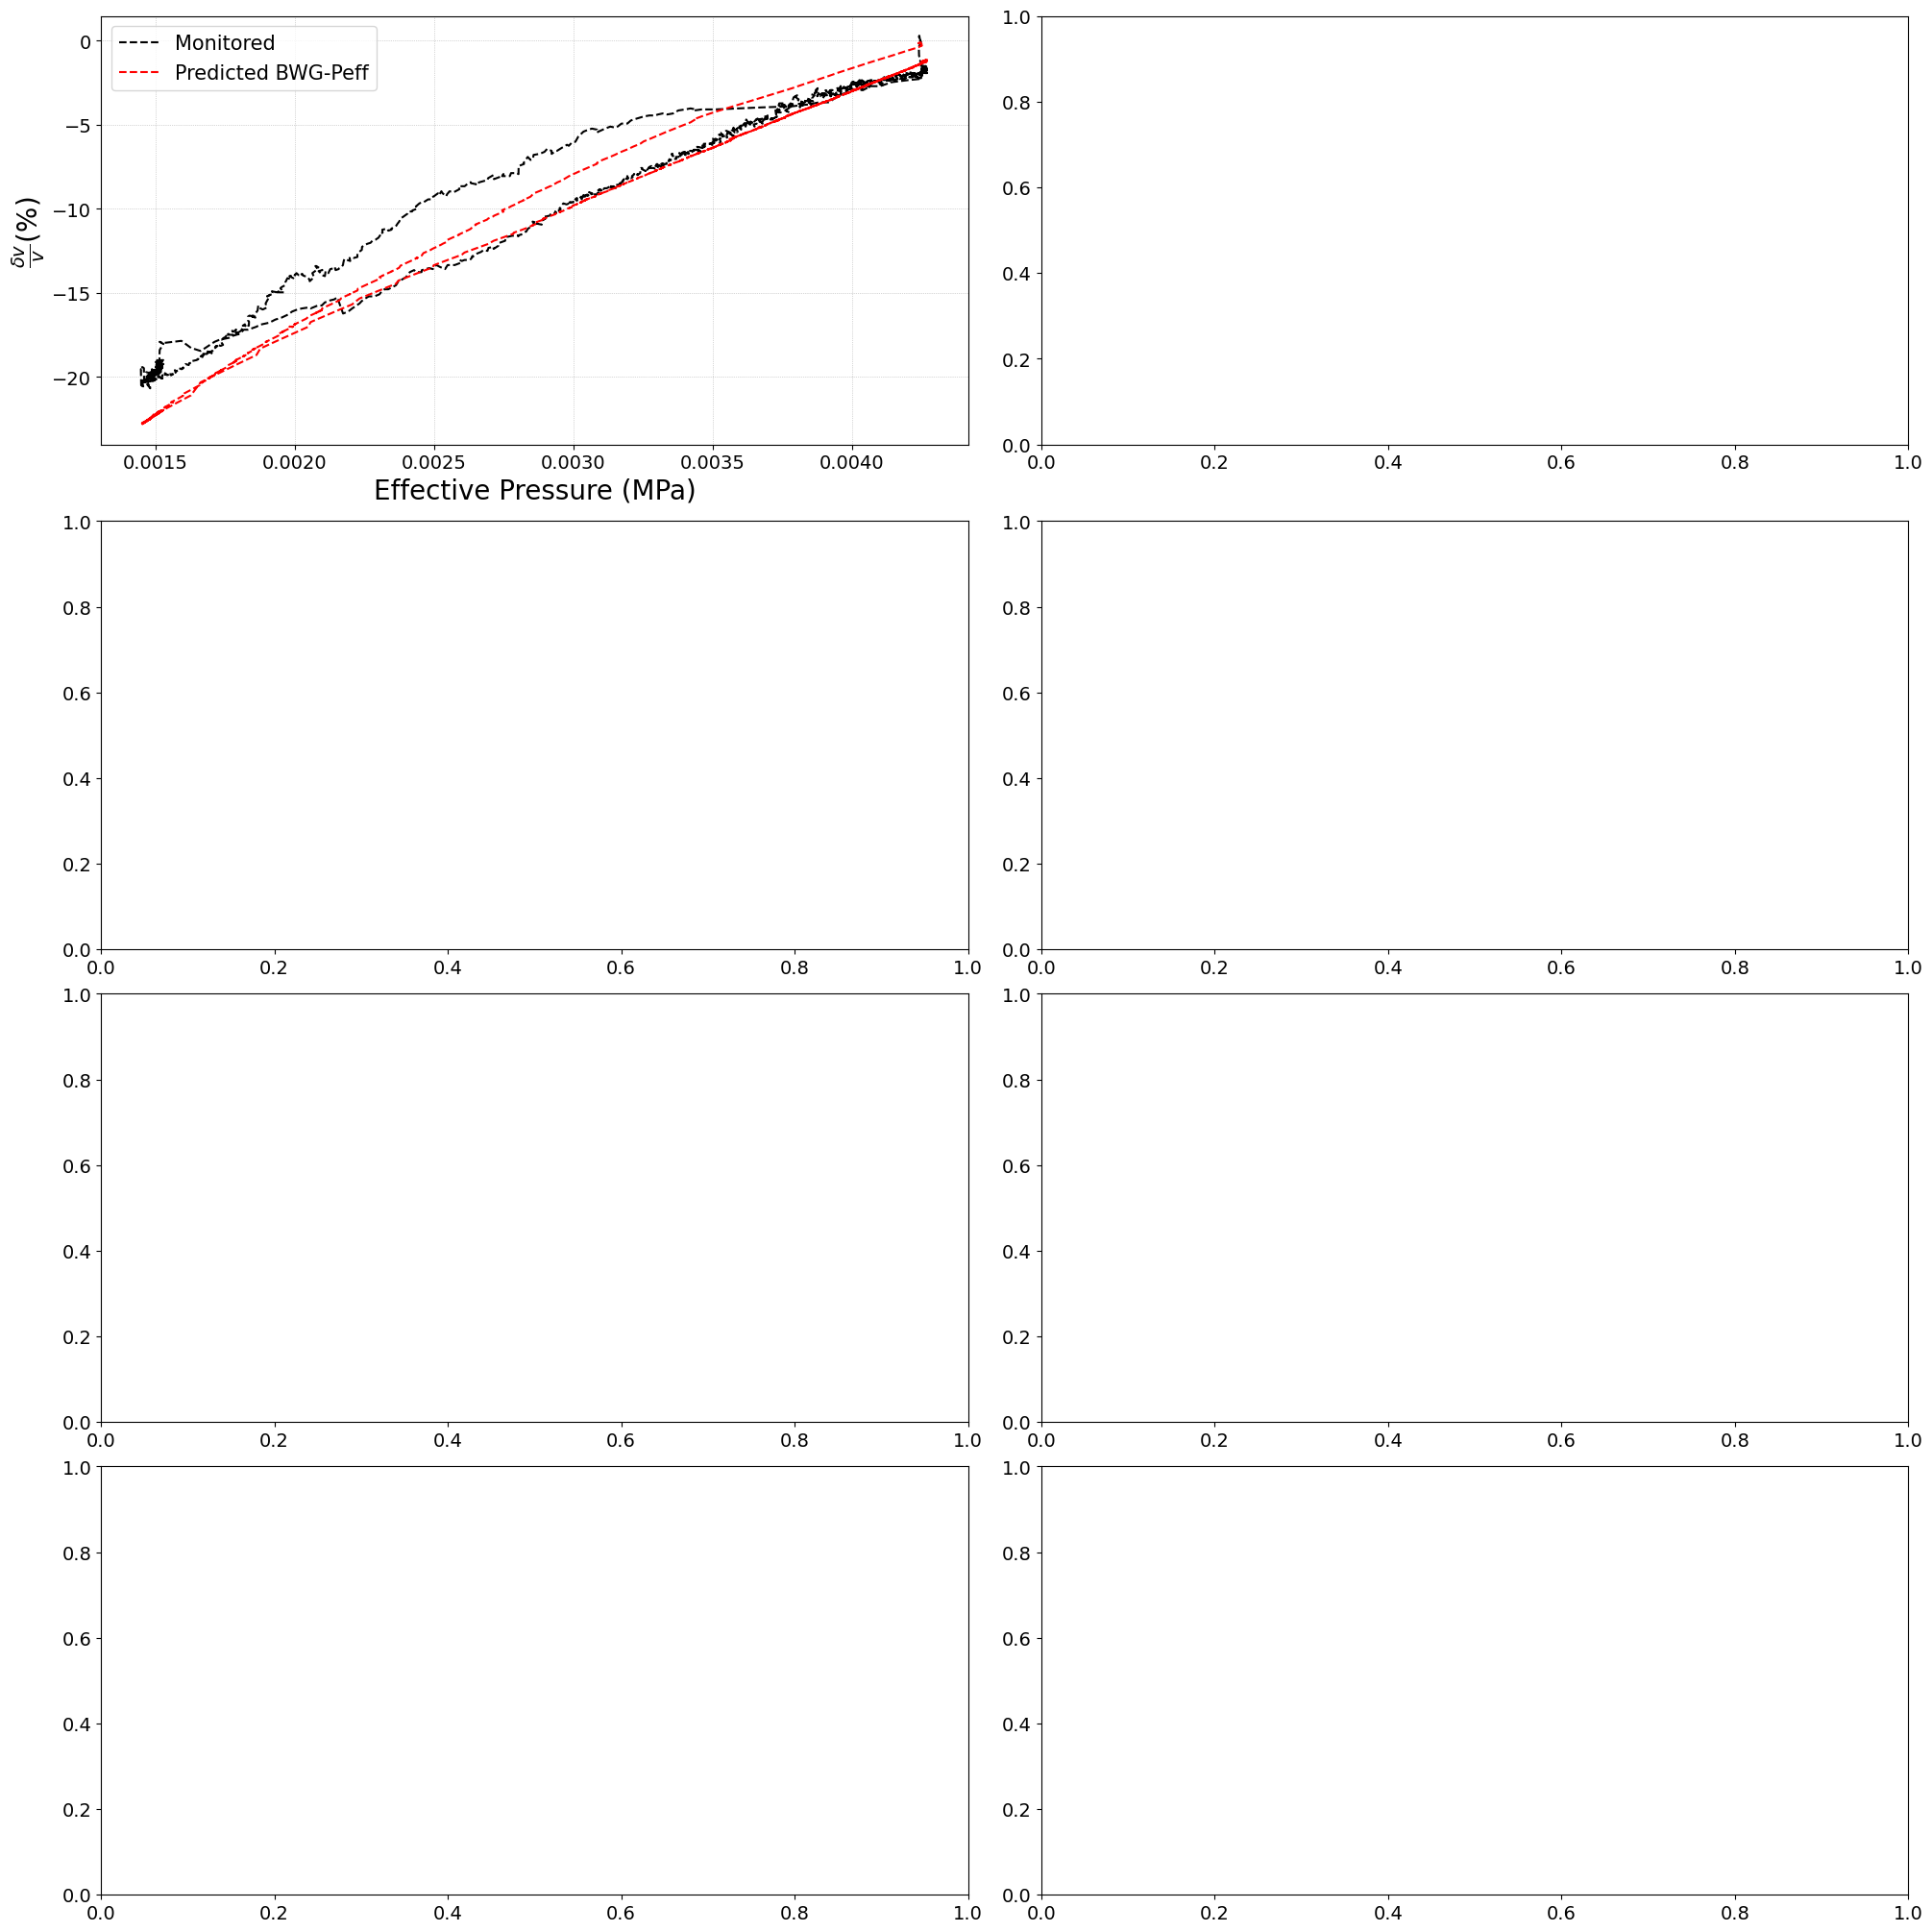

In [82]:
d=1
t1=59
t2=260
t3=320
t4=950
t5=1440
t6=1723
t7=1840
t8=2100
t9=2100
t10=2300
ti=[t1,t3,t5,t7]
tf=[t2,t4,t6,t8]

#v=np.asarray([63.2,62.7,62.2,60.6,60.2,58.2,56.5,53.1,48.6,48.6,52.2,55.5,59,59.9,60.2,62.4,63,64.6])
#times=np.asarray([1440,1445,1448,1451,1453,1456,1465,1473,1490,1565,1570,1575,1585,1595,1605,1625,1648,1723])
dc_data=np.loadtxt(r'C:\Hydro_modele/vitesse400.txt')
dc_data=np.asarray(dc_data)
v=dc_data[:,1]
times=dc_data[:,0].astype('int')
T=np.linspace(0,72*60,72*60*6)
f,ax = plt.subplots(4,2,figsize=(20,20),constrained_layout=True)
ax=ax.ravel()
dvf1=200
dvf2=300
DV=np.asarray(DV)
k=2
l=0
d=np.asarray([0,3.7,6.7,9.8,14.6,18,24.1,28.7,33.6,39])*10**-2
D=[]


for i in range(0,8):
    y=DVPEFF[i]#-dvff[i][1440*6]
    y=np.asarray(y)
    #im0=ax[i].scatter(Peff[k][(T>t5)&(T<t6)],y[(T>t5)&(T<t6)],c=T[(T>t5)&(T<t6)],s=10)
    ax[i].set_xlabel('Peff (Mpa)')
    ax[i].set_ylabel(r'$\delta v$ ')
    ax[i].plot(Peff[1][(T>t5)&(T<t6)],dvff[i][(T>t5)&(T<t6)]-dvff[i][1440*6],'k--',label='Monitored')#,linewidth=0.5)
    ax[i].plot(Peff[1][(T>t5)&(T<t6)],y[(T>t5)&(T<t6)],'r--',label='Predicted BWG-Peff')#,linewidth=0.5)
    ax[i].legend(fontsize=15)
    ax[i].grid()
    ax[i].set_xlabel('Effective Pressure (MPa)',fontsize=20)
    ax[i].set_ylabel(r'$\frac{\delta v}{v} (\%)$ ',fontsize=20)
    cbar=f.colorbar(im0, ax=ax[i],cmap='seismic_r')
    cbar.ax.set_ylabel('Monitoring time',fontsize=20)
    cbar.ax.tick_params(axis='both', which='major', labelsize=10)
    ax[i].set_title(f'frequency : {dvf1}-{dvf2}',fontsize=20,y=1,fontweight="bold")
    dvf1+=25
    dvf2+=25
    ax[i].tick_params(axis='both', which='minor', labelsize=35)

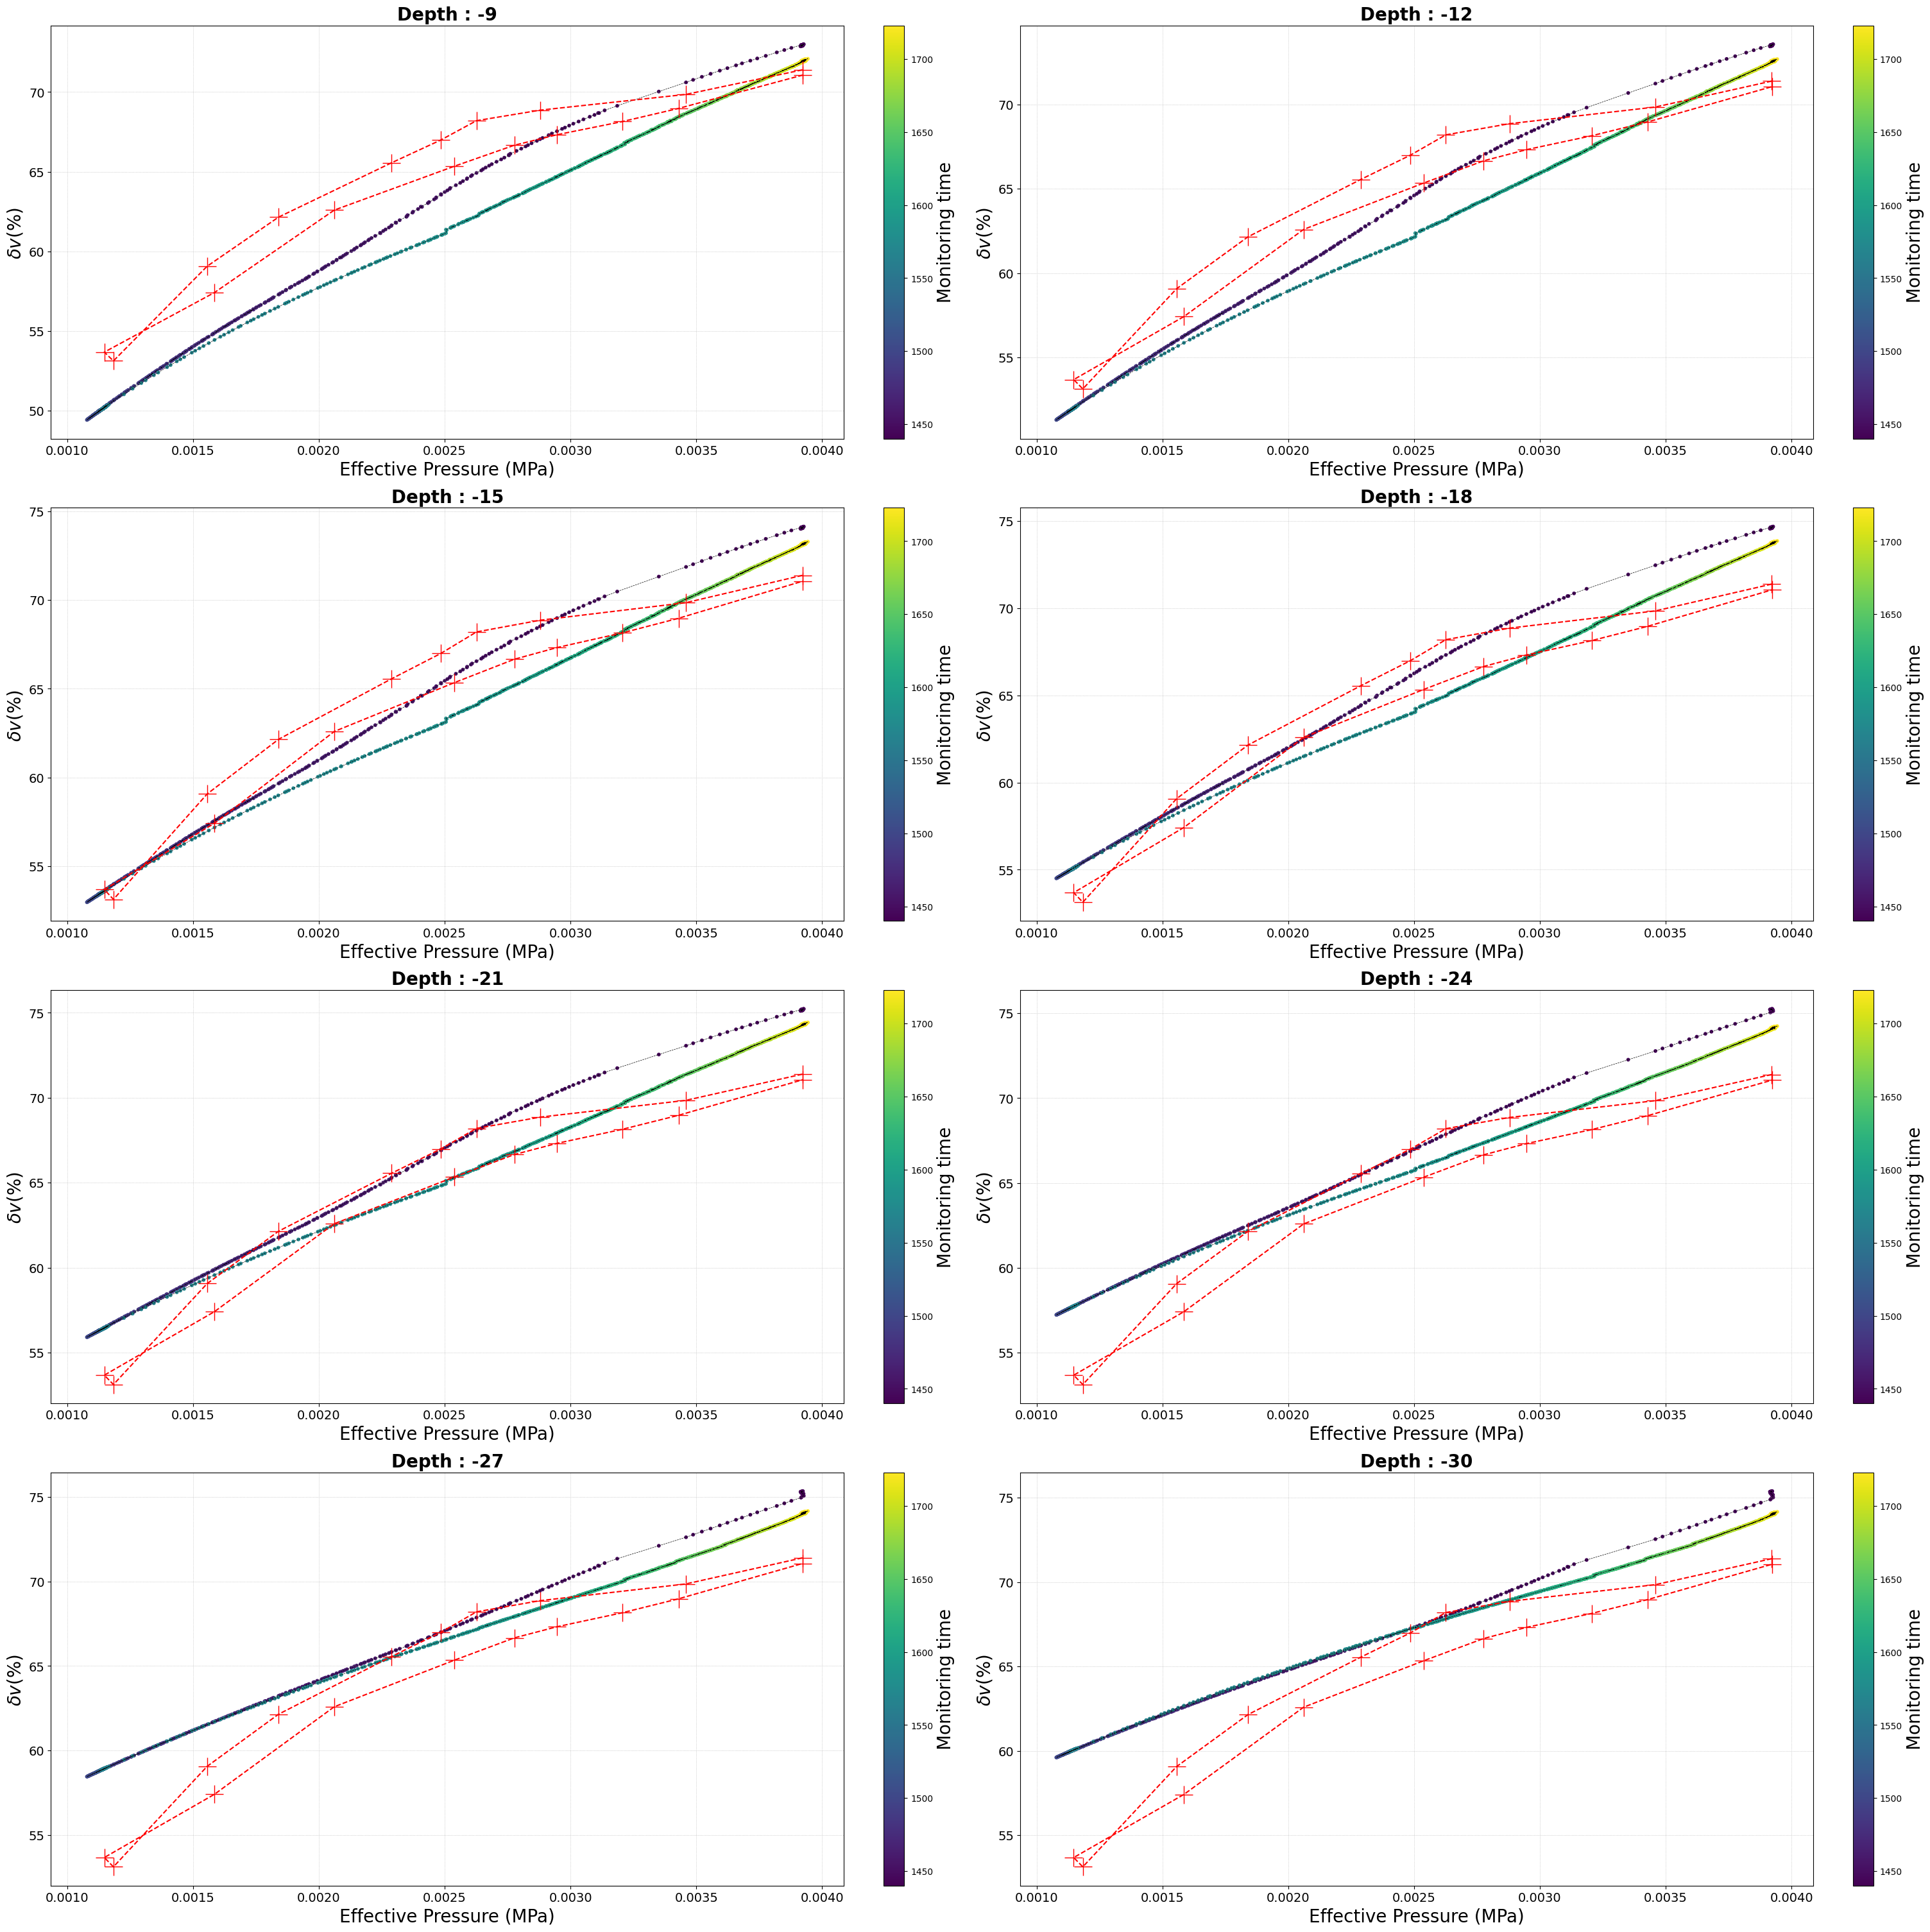

In [22]:
d=1
t1=59
t2=260
t3=320
t4=950
t5=1440
t6=1723
t7=1840
t8=2100
t9=2100
t10=2300
ti=[t1,t3,t5,t7]
tf=[t2,t4,t6,t8]

#v=np.asarray([63.2,62.7,62.2,60.6,60.2,58.2,56.5,53.1,48.6,48.6,52.2,55.5,59,59.9,60.2,62.4,63,64.6])
#times=np.asarray([1440,1445,1448,1451,1453,1456,1465,1473,1490,1565,1570,1575,1585,1595,1605,1625,1648,1723])
dc_data=np.loadtxt(r'C:\Hydro_modele/vitesse400.txt')
dc_data=np.asarray(dc_data)
v=dc_data[:,1]
times=dc_data[:,0].astype('int')
T=np.linspace(0,72*60,dvff[0].size)
f,ax = plt.subplots(4,2,figsize=(30,30),constrained_layout=True)
ax=ax.ravel()
dvf1=200
dvf2=300
DV=np.asarray(DV)
k=13

for i in range(0,8):
    y=1000*Vs_refz[i]#-dvff[i][1440*6]
    im0=ax[i].scatter(Peff[0][(T>t5)&(T<t6)],y[(T>t5)&(T<t6)],c=T[(T>t5)&(T<t6)],s=10)
    ax[i].set_xlabel('Peff (Mpa)')
    ax[i].set_ylabel(r'$\delta v$ ')
    ax[i].plot(Peff[0][(T>t5)&(T<t6)],y[(T>t5)&(T<t6)],'k--',linewidth=0.5)
    ax[i].plot(Peff[0][times*6],1.1*v,'r+--',markersize=20)
    #im0=ax[i].scatter(Peff[k][(T>t5)&(T<t6)],DV[i][(T>t5)&(T<t6)]-DV[i][1442*6],c=T[(T>t5)&(T<t6)],s=2)

    ax[i].grid()
    ax[i].set_xlabel('Effective Pressure (MPa)',fontsize=20)
    ax[i].set_ylabel(r'$\delta v (\%)$ ',fontsize=20)
    cbar=f.colorbar(im0, ax=ax[i],cmap='seismic_r')
    cbar.ax.set_ylabel('Monitoring time',fontsize=20)
    cbar.ax.tick_params(axis='both', which='major', labelsize=10)
    ax[i].set_title(f'Depth : {depth[i]}',fontsize=20,y=1,fontweight="bold")
    dvf1+=25
    dvf2+=25
    ax[i].tick_params(axis='both', which='minor', labelsize=25)

#    ax[1].set_title('(b)',fontsize=20,y=1,fontweight="bold")
#plt.savefig('F:\Fig_to_make/Hysteresys_brute.pdf',format='pdf',bbox_inches='tight',dpi=300)
#plt.savefig('F:\Fig_to_make/Hysteresys_brute.jpg',format='jpg',bbox_inches='tight',dpi=300)


### Figure papier

## BGW 

C:\Users\tgaubert001\.conda\envs\Acquisition\lib\site-packages\ipykernel_launcher.py:101: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


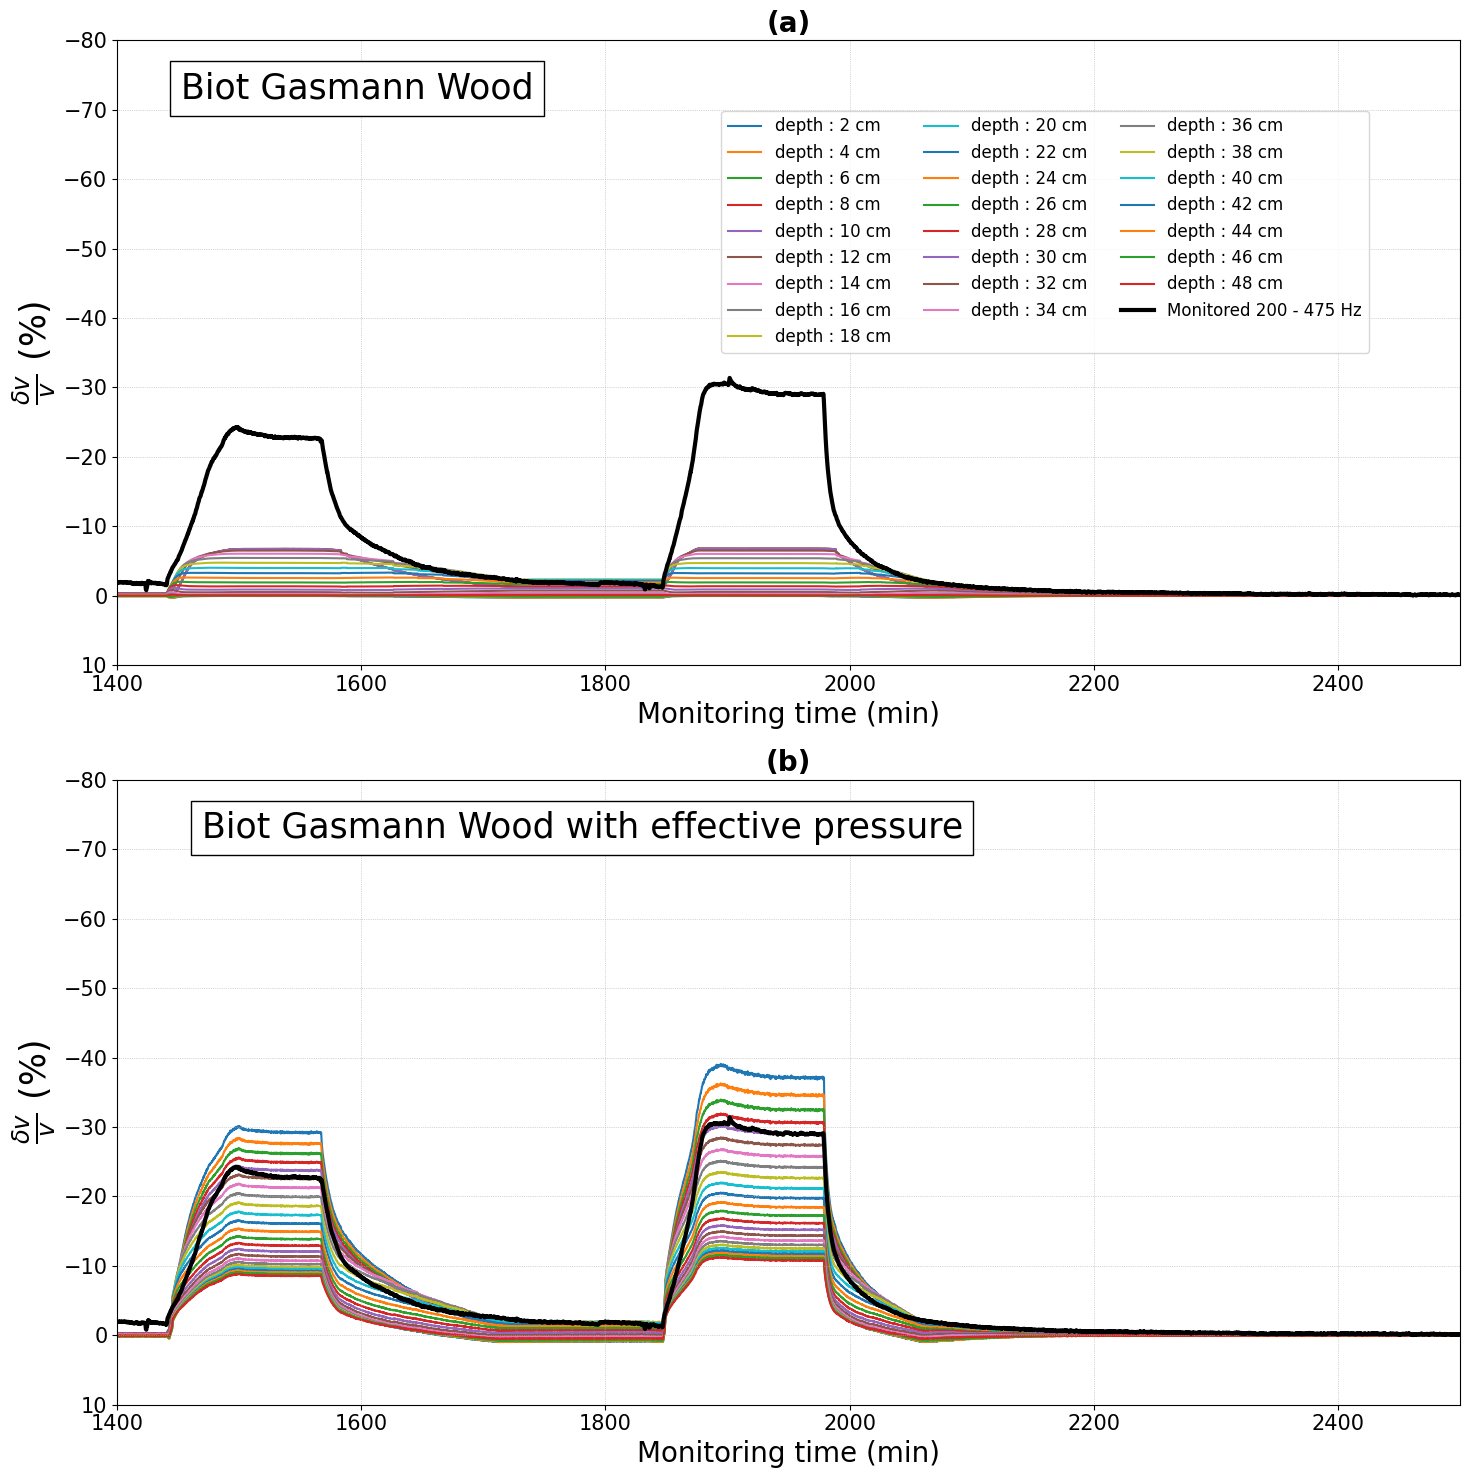

In [15]:
dvR=np.load('G:/Final_frequency_dv_15_trace.npy')
dvR=np.asarray(dvR)
dvR=np.mean(dvR[0:8,:],0)
tT=np.linspace(0,72*60,dvR.size)
BG=np.load('G:/Bg.npy')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(15,15),constrained_layout=True)
C=['(a)','(b)']
gs = gridspec.GridSpec(2, 2)
ax4 = plt.subplot(gs[0, :])
ax1 = plt.subplot(gs[1, :])
ax=ax1
data=[]
for i in range(0,New_Depth.size):#depth.size-1):
    ax.plot(tT,dvs2[i],label=f'Depth : {abs(New_Depth[i])} cm',zorder=1)
    data.append(dvs2[i])
ax.plot(tT,dvR,'black',label=f'Monitored {200} - {475} Hz',linewidth=3,zorder=2)
ax.set_xlim(1400,2500)
ax.set_xlabel('Monitoring time (min)',fontsize=20)
ax.set_ylabel(r'$\delta v$ (%)',fontsize=20)
ax.grid()
ax.set(xlabel='Monitoring time (min)', xlim=[1400,2500],
       ylabel=r'$\frac{\delta v}{v}$ (%)', ylim=[-80,10])
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.set_ylabel(r'$\frac{\delta v}{v}$ (%)',fontsize=25)
ax.set_ylim(10,-80)
ax.annotate(r'Biot Gasmann Wood with effective pressure', (1400, -70),
            xytext=(0.63, 0.95), textcoords='axes fraction',
            ha="right", va="top",
            bbox=dict(boxstyle="square",
                   ec=(0., 0, 0),
                   fc=(1., 1, 1),
                   )    ,        
            fontsize=25,
            horizontalalignment='right', verticalalignment='top')
ax.set_title('(b)',fontsize=20,y=1,fontweight="bold")
ax=ax2
'''
plt.text(2218,35, "WET", size=20,
         ha="right", va="top",
         bbox=dict(boxstyle="square",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8),
                   )
         )
'''
#plt.text(1611,35, "DRY", size=20,
#         ha="right", va="top",
#         bbox=dict(boxstyle="square",
#                   ec=(1., 0.5, 0.5),
#                   fc=(1., 0.8, 0.8),
#                   )
#         )
ax.set_xlim(0,0.3)
ax.set_ylim(0.29,0)
ax.set_xlabel('Sensitivity R to Vs',fontsize=20)
ax.set_ylabel('Depth (m)',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.grid()
ax=ax3
ax.set_xlim(0,0.3)
ax.set_ylim(0.29,0)
ax.set_xlabel('Sensitivity R to Vs',fontsize=20)
ax.set_ylabel('Depth (m)',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
#ax.set_title(C[2],fontsize=20,y=1,fontweight="bold")
ax.grid()
ax=ax4
for i in range(0,New_Depth.size):#depth.size-1):
    ax.plot(tT,dvGBW[i],label=f'depth : {abs(New_Depth[i])} cm')

ax.plot(tT,dvR,'k',label=f'Monitored {200} - {475} Hz',linewidth=3,zorder=2)
ax.set_xlim(1400,2500)
#ax.legend(fontsize=12,loc=(0.7,0.15))
ax.grid()
ax.set(xlabel='Monitoring time (min)', xlim=[1400,2500],
       ylabel=r'$\delta v$ (%)', ylim=[-80,10])
ax.set_xlabel('Monitoring time (min)',fontsize=20)
ax.set_ylabel(r'$\frac{\delta v}{v}$ (%)',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.set_title('(a)',fontsize=20,y=1,fontweight="bold")
ax.set_ylabel(r'$\frac{\delta v}{v}$ (%)',fontsize=25)
ax.set_ylim(10,-80)
ax.annotate(r'Biot Gasmann Wood', (1400, -70),
            xytext=(0.31, 0.95), textcoords='axes fraction',
            ha="right", va="top",
            bbox=dict(boxstyle="square",
                   ec=(0., 0, 0),
                   fc=(1., 1, 1),
                   )    ,        
            fontsize=25,
            horizontalalignment='right', verticalalignment='top')
ax.legend(fontsize=12,loc=(0.45,0.5),ncol=3)

fig.tight_layout()

#plt.savefig('F:\Fig_to_make/ModelKernel_Sw.pdf',format='pdf',bbox_inches='tight',dpi=300)
#plt.savefig('F:\Fig_to_make/ModelKernel_Sw.jpg',format='jpg',bbox_inches='tight',dpi=300)

In [107]:
Vsfig=np.concatenate((Vs_refz[0],Vs_refz))


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

In [109]:
a = np.array([[1, 2], [3, 4]])

b = np.array([[5, 6]])

np.concatenate((a, b), axis=0)

array([[1, 2],
       [3, 4],
       [5, 6]])

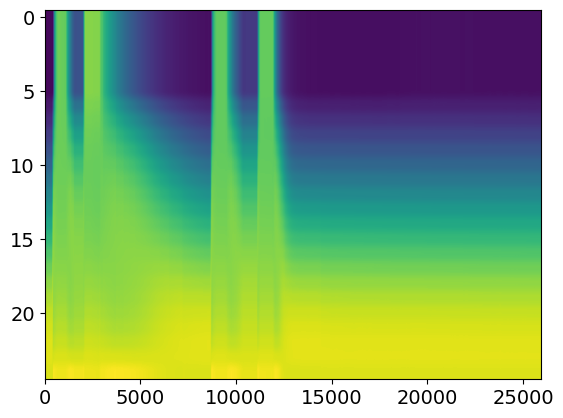

In [155]:

dvP

array([0.1357869 , 0.1357869 , 0.1370064 , 0.1370064 , 0.13819264,
       0.13819264, 0.13934772, 0.13934772, 0.14047357, 0.14047357,
       0.14095466, 0.14095466, 0.14156637, 0.14156637, 0.14228728,
       0.14228728, 0.14309672, 0.14309672, 0.14397535, 0.14397535,
       0.14490585, 0.14490585, 0.14587334, 0.14587334, 0.14686533,
       0.14686533, 0.14787125, 0.14787125, 0.14888172, 0.14888172,
       0.14988799, 0.14988799, 0.1508817 , 0.1508817 , 0.15185525,
       0.15185525, 0.15280304, 0.15280304, 0.15372406, 0.15372406,
       0.15462777, 0.15462777, 0.15554824, 0.15554824, 0.15658636,
       0.15658636, 0.15807864, 0.15807864])

In [156]:
dvP,dvS,dvRho,prof=__function_staircase(-New_depthfig,Vpfig,Vsfig,Rhofig,times[0]*6)


In [160]:
np.asarray(dvP[0])

array(0.14507988)

In [161]:
dvP=np.concatenate((np.asarray([dvP[0]]),dvP))

In [90]:
times[14]

1605

## Velocity modelling 

C:\Users\tgaubert001\.conda\envs\Acquisition\lib\site-packages\ipykernel_launcher.py:138: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


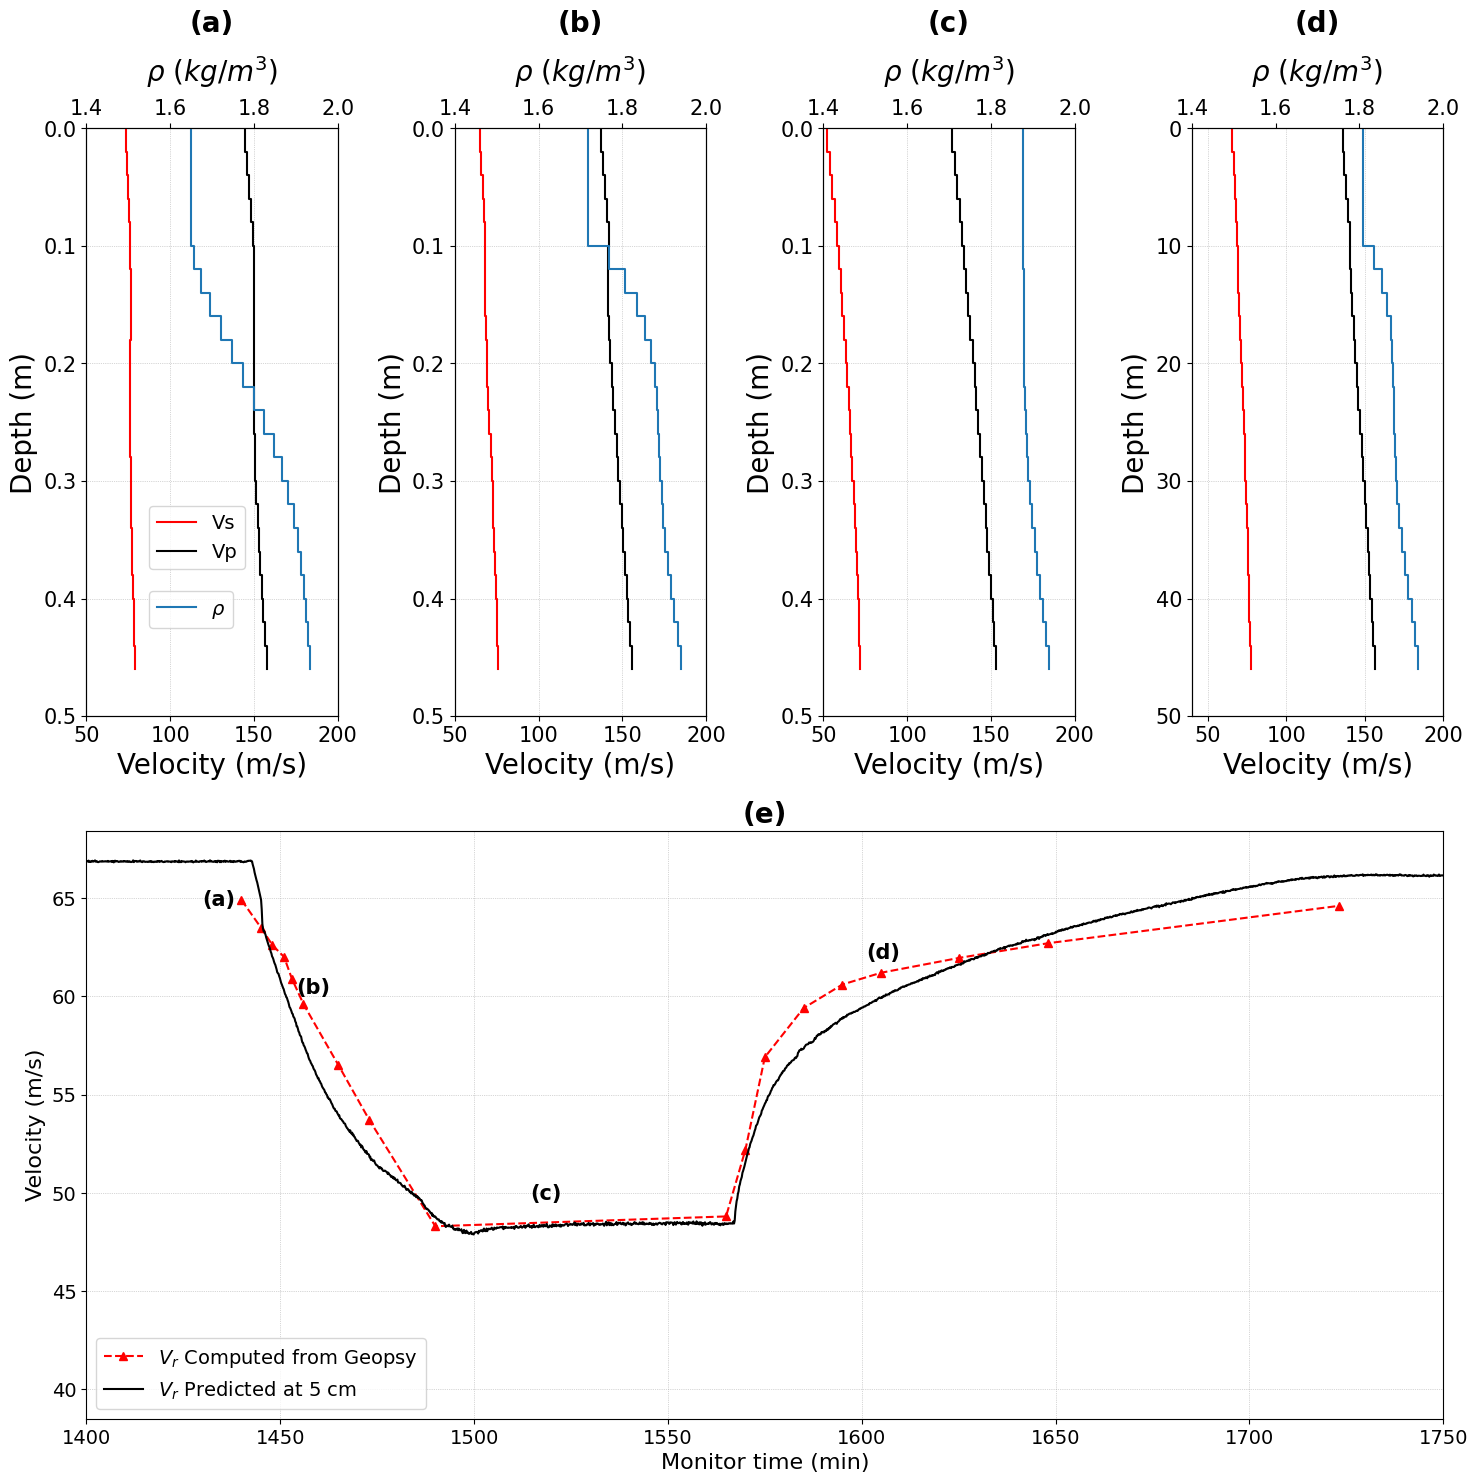

In [19]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
New_Depth=-np.arange(0,48,2)

fig = plt.figure(figsize=(15,15),constrained_layout=True)
gs = gridspec.GridSpec(4, 4)
ax1 = plt.subplot(gs[0:2,0])
ax2 = plt.subplot(gs[0:2, 1])
ax3 = plt.subplot(gs[0:2, 2])
ax4 = plt.subplot(gs[0:2, 3])
ax5 = plt.subplot(gs[2::, :])


dvP,dvS,dvRho,prof=__function_staircase(-New_Depth,Vp_refz,Vs_refz,Rho[0],times[0]*6)
#dvP=np.concatenate((np.asarray([dvP[0]]),dvP))
#dvS=np.concatenate((np.asarray([dvS[0]]),dvS))
#dvRho=np.concatenate((np.asarray([dvRho[0]]),dvRho))
#prof=np.concatenate((np.asarray([0]),prof))
prof=prof*10**-2
ax1.plot(dvS*1000,prof,'r',label='Vs')
ax1.plot(dvP*1000,prof,'k',label='Vp')
ax1.set_ylim(0.5,0)
ax11 = ax1.twiny()
ax11.plot(dvRho,prof,label=r'$\rho$')
ax11.set_xlim(1.4,2)
ax11.set_xlabel(r'$\rho \ (kg/m^3)$',fontsize=20,labelpad=12)
ax1.set_xlabel('Velocity (m/s)',fontsize=20)
ax1.grid()
ax1.set_ylabel('Depth (m)',fontsize = 20)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax11.tick_params(axis='both', which='major', labelsize=15)
ax1.set_xlim(50,200)
ax11.legend(loc=(0.25,0.15))
ax1.legend(loc=(0.25,0.25))


dvP,dvS,dvRho,prof=__function_staircase(-New_Depth,Vp_refz,Vs_refz,Rho[0],times[4]*6)
dvP=np.concatenate((np.asarray([dvP[0]]),dvP))
dvS=np.concatenate((np.asarray([dvS[0]]),dvS))
dvRho=np.concatenate((np.asarray([dvRho[0]]),dvRho))
prof=np.concatenate((np.asarray([0]),prof))
prof=prof*10**-2
ax2.plot(dvS*1000,prof,'r')
ax2.plot(dvP*1000,prof,'k')
ax2.set_ylim(0.5,0)
ax22 = ax2.twiny()
ax22.plot(dvRho,prof)
ax22.set_xlim(1.4,2)
ax22.set_xlabel(r'$\rho \ (kg/m^3)$',fontsize=20,labelpad=12)
ax2.set_xlabel('Velocity (m/s)',fontsize=20)
ax2.grid()
ax2.set_ylabel('Depth (m)',fontsize = 20)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax22.tick_params(axis='both', which='major', labelsize=15)
ax2.set_xlim(50,200)



dvP,dvS,dvRho,prof=__function_staircase(-New_Depth,Vp_refz,Vs_refz,Rho[0],1530*6)
dvP=np.concatenate((np.asarray([dvP[0]]),dvP))
dvS=np.concatenate((np.asarray([dvS[0]]),dvS))
dvRho=np.concatenate((np.asarray([dvRho[0]]),dvRho))
prof=np.concatenate((np.asarray([0]),prof))
prof=prof*10**-2
ax3.plot(dvS*1000,prof,'r')
ax3.plot(dvP*1000,prof,'k')
ax3.set_ylim(0.5,0)
ax33 = ax3.twiny()
ax33.plot(dvRho,prof)
ax33.set_xlim(1.4,2)
ax33.set_xlabel(r'$\rho \ (kg/m^3)$',fontsize=20,labelpad=12)
ax3.set_xlabel('Velocity (m/s)',fontsize=20)
ax3.grid()
ax3.set_ylabel('Depth (m)',fontsize = 20)
ax3.tick_params(axis='both', which='major', labelsize=15)
ax33.tick_params(axis='both', which='major', labelsize=15)
ax3.set_xlim(50,200)

dvP,dvS,dvRho,prof=__function_staircase(-New_Depth,Vp_refz,Vs_refz,Rho[0],times[14]*6)
dvP=np.concatenate((np.asarray([dvP[0]]),dvP))
dvS=np.concatenate((np.asarray([dvS[0]]),dvS))
dvRho=np.concatenate((np.asarray([dvRho[0]]),dvRho))
prof=np.concatenate((np.asarray([0]),prof))
ax4.plot(dvS*1000,prof,'r')
ax4.plot(dvP*1000,prof,'k')
ax4.set_ylim(50,0)
ax44 = ax4.twiny()
ax44.plot(dvRho,prof)
ax44.set_xlim(1.4,2)
ax44.set_xlabel(r'$\rho \ (kg/m^3)$',fontsize=20,labelpad=12)
ax4.set_xlabel('Velocity (m/s)',fontsize=20)
ax4.grid()
ax4.set_ylabel('Depth (m)',fontsize = 20)
ax4.tick_params(axis='both', which='major', labelsize=15)
ax44.tick_params(axis='both', which='major', labelsize=15)
ax4.set_xlim(40,200)


tT=np.linspace(0,72*60,Vs_refz[0].size)
ax5.plot(times,v,'^r--', label=f'$V_r$ Computed from Geopsy')
ax5.plot(tT,0.9*1000*Vs_refz[1],'k',label='$V_r$ Predicted at 5 cm')
ax5.set_xlim(1400,1750)
ax5.legend()
ax5.grid()
ax5.set_ylabel('Velocity (m/s)')
ax5.set_xlabel('Monitor time (min)')
ax1.set_title('(a)',fontsize=20,y=1.15,fontweight="bold")
ax2.set_title('(b)',fontsize=20,y=1.15,fontweight="bold")
ax3.set_title('(c)',fontsize=20,y=1.15,fontweight="bold")
ax4.set_title('(d)',fontsize=20,y=1.15,fontweight="bold")
ax5.set_title('(e)',fontsize=20,y=1,fontweight="bold")

ax5.annotate(r'(a)', (1450, 60),
            xytext=(0.11, 0.9), textcoords='axes fraction',fontweight="bold",
            ha="right", va="top",      
            fontsize=15,
            horizontalalignment='right', verticalalignment='top')
ax5.annotate(r'(b)', (1453, 60),
            xytext=(0.18, 0.75), textcoords='axes fraction',fontweight="bold",
            ha="right", va="top",      
            fontsize=15,
            horizontalalignment='right', verticalalignment='top')

ax5.annotate(r'(c)', (1453, 60),
            xytext=(0.35, 0.4), textcoords='axes fraction',fontweight="bold",
            ha="right", va="top",      
            fontsize=15,
            horizontalalignment='right', verticalalignment='top')

ax5.annotate(r'(d)', (1453, 60),
            xytext=(0.6, 0.81), textcoords='axes fraction',fontweight="bold",
            ha="right", va="top",      
            fontsize=15,
            horizontalalignment='right', verticalalignment='top')
fig.tight_layout()
#plt.savefig('F:\Fig_to_make/Velocity_model.pdf',format='pdf',bbox_inches='tight',dpi=300)
#plt.savefig('F:\Fig_to_make/Velocity_model.jpg',format='jpg',bbox_inches='tight',dpi=300)

In [21]:
New_Depth[1]

-2

## Kernel

In [22]:
dvf1=200
dvf2=300
Kpef=[]
Ksol=[]
for i in range(8):
    KernelPeff=np.load(rf'C:\Hydro_modele\Kernel\Frequence\Peff_52_{dvf1}_{dvf2}_Kernel_end.npy',allow_pickle=True)
    idxPeff=np.load(rf'C:\Hydro_modele\Kernel\Frequence\Peff_52_{dvf1}_{dvf2}_indice_end.npy',allow_pickle=True)
    KernelSol=np.load(rf'C:\Hydro_modele\Kernel\Frequence\Peff_50_{dvf1}_{dvf2}_Kernel_end.npy',allow_pickle=True)
    idxSol=np.load(rf'C:\Hydro_modele\Kernel\Frequence\Peff_50_{dvf1}_{dvf2}_indice_end.npy',allow_pickle=True)
    Kpef.append(KernelPeff)
    Ksol.append(KernelSol)
    dvf1+=25
    dvf2+=25

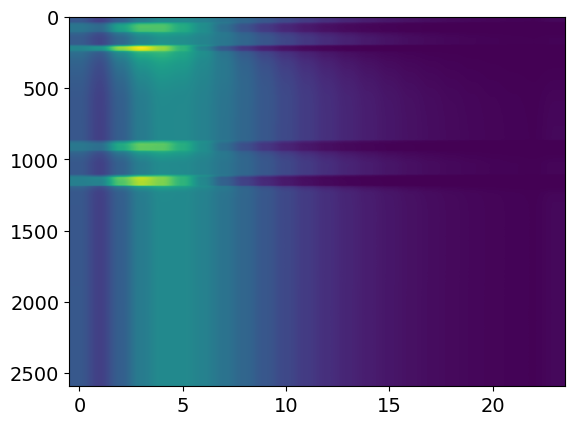

In [88]:
plt.imshow(Kpef[0],aspect='auto')

[8640, 8718, 9180, 9630]


C:\Users\tgaubert001\.conda\envs\Acquisition\lib\site-packages\ipykernel_launcher.py:38: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


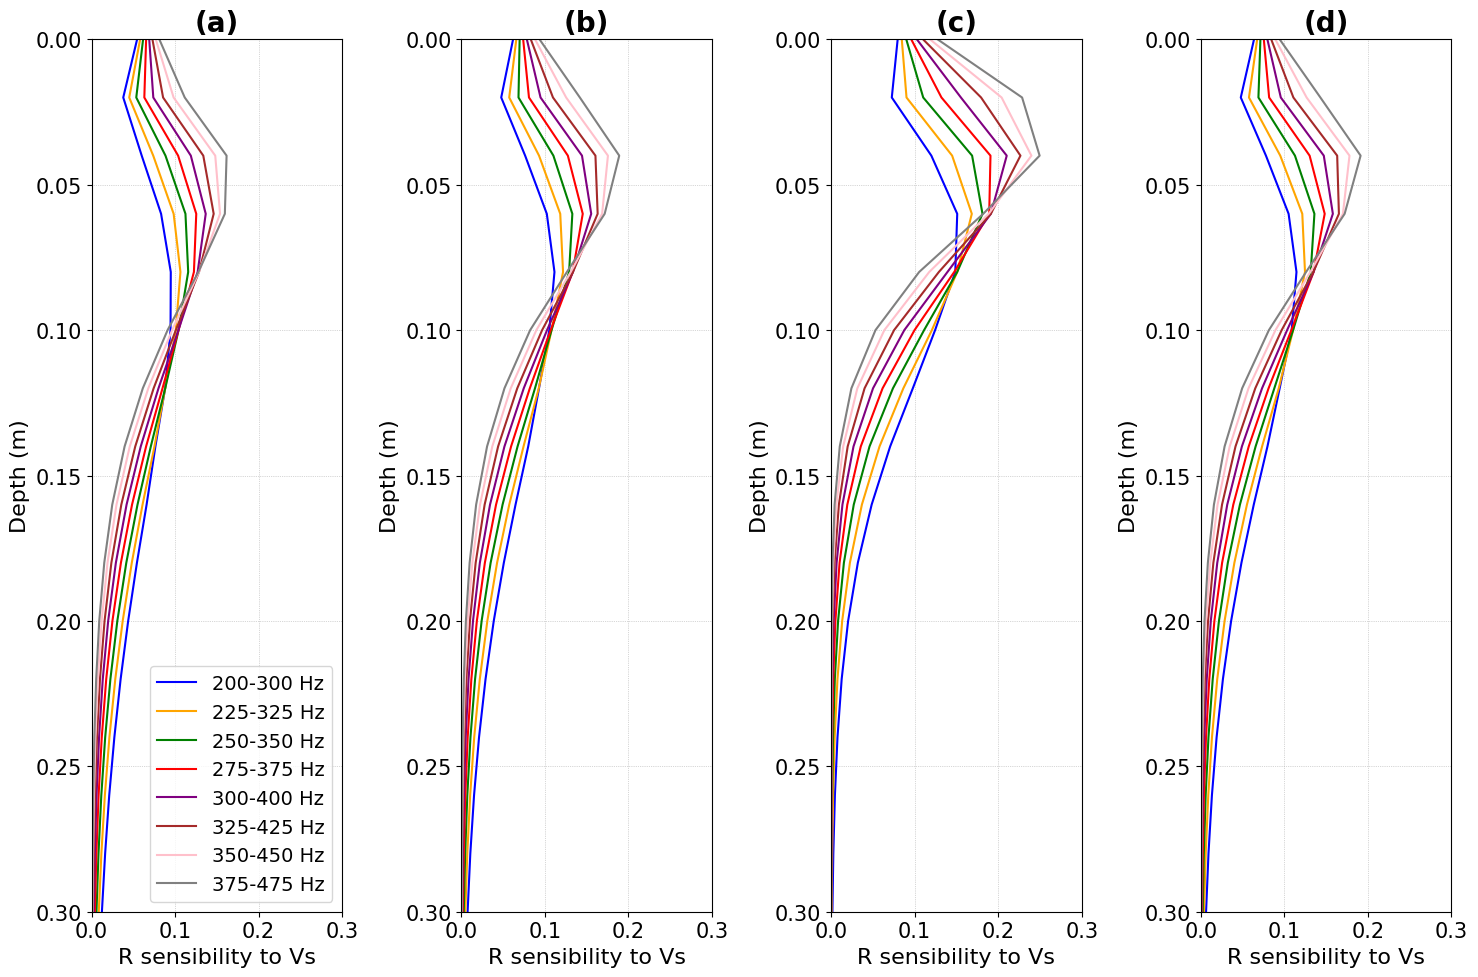

In [23]:
fig = plt.figure(figsize=(15,10),constrained_layout=True)
gs = gridspec.GridSpec(2, 4)
ax1 = plt.subplot(gs[0:2,0])
ax2 = plt.subplot(gs[0:2, 1])
ax3 = plt.subplot(gs[0:2, 2])
ax4 = plt.subplot(gs[0:2, 3])
ax1.set_title('(a)',fontsize=20,y=1,fontweight="bold")
ax2.set_title('(b)',fontsize=20,y=1,fontweight="bold")
ax3.set_title('(c)',fontsize=20,y=1,fontweight="bold")
ax4.set_title('(d)',fontsize=20,y=1,fontweight="bold")

ax=[ax1,ax2,ax3,ax4]
i=0
ts=[times[0]*6,times[4]*6,1530*6,times[14]*6]
print(ts)
d=np.arange(0,48,2)
d=d*10**-2
colors=np.asarray(['b','orange','g','r','purple','brown','pink','gray'])
for i in range(len(ts)):
    f1=200
    f2=300
    axs=ax[i]
    j=0
    while j < len(Kpef):
        axs.plot(Kpef[j][ts[i]//10][0:24],d,color=colors[j],label=f'{f1}-{f2} Hz')
        #axs.plot(Ksol[j][ts[i]//60][0:24],d,'--',label=f'{f1}-{f2} Hz')
        j+=1
        f1+=25
        f2+=25
    axs.grid()
    axs.set_xlabel('R sensibility to Vs')
    axs.set_ylabel('Depth (m)')
    axs.set_ylim(0.3,0)
    axs.tick_params(axis='both', which='major', labelsize=15)
    axs.set_xlim(0,0.3)

ax[0].legend()
fig.tight_layout()
#plt.savefig('F:\Fig_to_make/Kernel_time.pdf',format='pdf',bbox_inches='tight',dpi=300)
#plt.savefig('F:\Fig_to_make/Kernel_time.jpg',format='jpg',bbox_inches='tight',dpi=300)

In [96]:
d

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46])

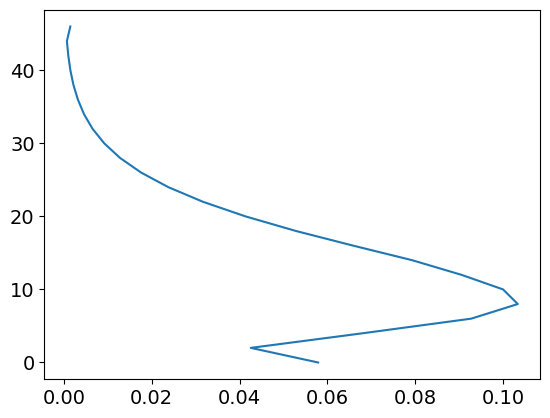

In [41]:
plt.plot(Kpef[j][ts[i]//60][0:24],d)

## Frequency fit 

0
(24, 25920)
1
(24, 25920)
2
(24, 25920)
3
(24, 25920)


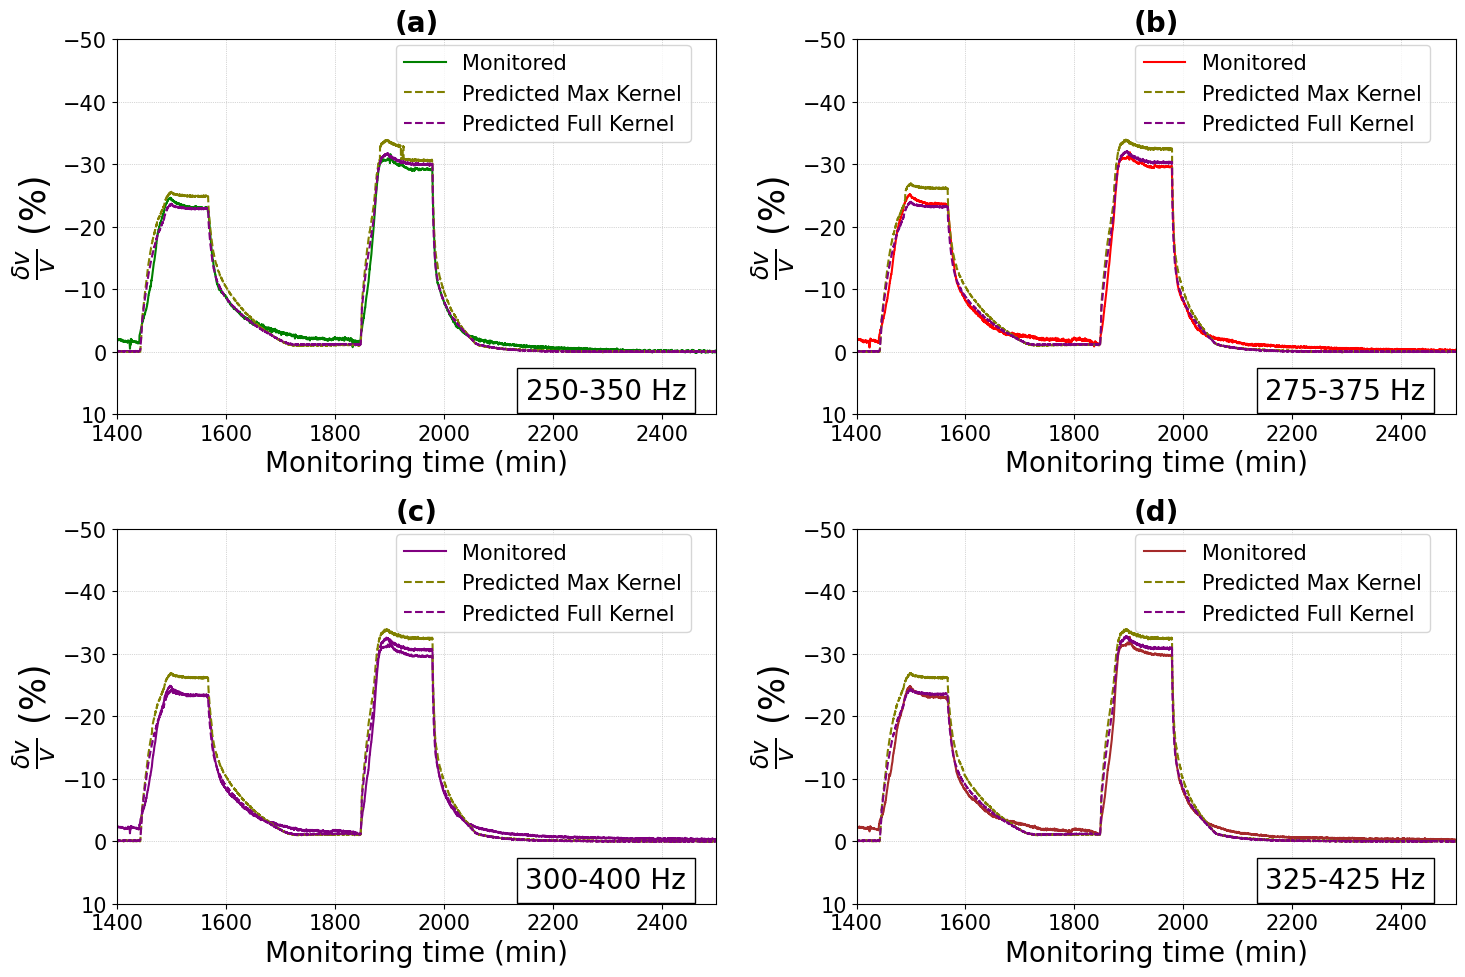

In [24]:
#dvff=np.load('G:/Final_frequency_dv.npy')
dvff=np.load('G:/Final_frequency_dv_15_trace.npy')
D=np.asarray(dvff)
DV=np.asarray(dvff)
from scipy import signal
col=np.asarray(['blue','orange','green','red','purple','brown','pink','grey'])
C=np.asarray(['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)'])
fig, axs = plt.subplots(2,2,figsize=(15,10), facecolor='w', edgecolor='k')
axs=axs.ravel()
dvf1=200
dvf2=300
dvwet=[]
DV=[]
dvdry=[]
dvf1=200
dvf2=300
DVSOLAZI=[]
DVPEFF=[]
colors=np.asarray(['b','orange','g','r','purple','brown','pink','gray'])
n=0
idx=np.asarray([2,3,4,5])
dvf1s=np.asarray([200,225,250,275,300,325,350,375])
dvf2s=np.asarray([200,225,250,275,300,325,350,375])+100
for i in range(idx.size):
    print(i)
    ax=axs[i]
    dvf1=dvf1s[idx[i]]
    dvf2=dvf2s[idx[i]]
    dv=dvff[idx[i]]#[8000::]
    t=tT#[8000::]
    ax.plot(t,dv,color=colors[idx[i]],label=f'Monitored')#
    #Kernel=np.load(rf'C:\Hydro_modele\Kernel\Frequence\{dvf1}_{dvf2}\Kernel_{0}.npy')
    KernelPeff=np.load(rf'C:\Hydro_modele\Kernel\Frequence\Peff_52_{dvf1}_{dvf2}_Kernel_end.npy',allow_pickle=True)
    idxPeff=np.load(rf'C:\Hydro_modele\Kernel\Frequence\Peff_52_{dvf1}_{dvf2}_indice_end.npy',allow_pickle=True)
    KernelSol=np.load(rf'C:\Hydro_modele\Kernel\Frequence\Peff_50_{dvf1}_{dvf2}_Kernel_end.npy',allow_pickle=True)
    idxSol=np.load(rf'C:\Hydro_modele\Kernel\Frequence\Peff_50_{dvf1}_{dvf2}_indice_end.npy',allow_pickle=True)
    data=[]
    data2=[]
    for j in range(0,New_Depth.size):#depth.size-1):
        data.append(dvs2[j])
        data2.append(dvs1[j])
    print(np.shape(data))
    dvv=[]
    dvvsolazi=[]
    data=np.asarray(data)
    data2=np.asarray(data2)
    dvvPeff=[]
    for k in range(25920):
        index_kernelP=(find_nearest(idxPeff,k))
        index_kernelS=(find_nearest(idxSol,k))
        #if  np.trapz((KernelPeff[index_kernel][0:24]))!=1:
        #    KernelPeff[index_kernel][0:24]=Kernel[index_kernel][0:24]*(1/np.trapz((Kernel[index_kernel][0:24])))
        dvvPeff.append(np.trapz((KernelPeff[index_kernelP][0:24])*data[:,k]))
        idxmax=np.argmax(KernelPeff[index_kernelP])
        dvvsolazi.append(data[idxmax,k])

    #ax.plot(tT,dvvsolazi,'--',color='olive',label=f'Predicted Solazi {dvf1}-{dvf1+100} Hz')
    ax.plot(tT,dvvsolazi,'--',color='olive',label=f'Predicted Max Kernel')
    ax.plot(tT,dvvPeff,'--',color='purple',label=f'Predicted Full Kernel')

    ax.set_xlim(1400,2500)
    ax.legend(fontsize=15,loc=(0.465,0.725))
    ax.grid()
    ax.set(xlabel='Monitoring time (min)', xlim=[1400,2500],
           ylabel=r'$\delta v$ (%)', ylim=[-50,10])
    ax.set_xlabel('Monitoring time (min)',fontsize=20)
    ax.set_ylabel(r'$\frac{\delta v}{v}$ (%)',fontsize=25)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=15)
    ax.set_title(C[i],fontsize=20,y=1,fontweight="bold")
    ax.set_ylim(10,-50)
    DVPEFF.append(np.asarray(dvvPeff))
    ax.annotate(rf'{dvf1}-{dvf2} Hz', (2200, 4),
            xytext=(0.95, 0.1), textcoords='axes fraction',
            ha="right", va="top",
            bbox=dict(boxstyle="square",
                   ec=(0., 0, 0),
                   fc=(1., 1, 1),
                   )    ,        
            fontsize=20,
            horizontalalignment='right', verticalalignment='top')    #ax.plot(tT,DV[i],'--',color='purple',label=f'Predicted {dvf1}-{dvf1+100} Hz')

    n+=1
fig.tight_layout()
#plt.savefig('F:\Fig_to_make/ModelKernelfrequency_color_interp_Sw_ref_4slot.pdf',format='pdf',bbox_inches='tight',dpi=300)
#plt.savefig('F:\Fig_to_make/ModelKernelfrequency_color_interp_Sw_ref_4slot.jpg',format='jpg',bbox_inches='tight',dpi=300)

## AC modelling 

In [188]:
DVAC=np.load(rf'G:/ACDV.npy')
dvf1=200
dvf2=300
Kpef=[]
Ksol=[]
for i in range(8):
    KernelPeff=np.load(rf'C:\Hydro_modele\Kernel\Frequence\Peff_52_{dvf1}_{dvf2}_Kernel_end.npy',allow_pickle=True)
    idxPeff=np.load(rf'C:\Hydro_modele\Kernel\Frequence\Peff_52_{dvf1}_{dvf2}_indice_end.npy',allow_pickle=True)
    KernelSol=np.load(rf'C:\Hydro_modele\Kernel\Frequence\Peff_50_{dvf1}_{dvf2}_Kernel_end.npy',allow_pickle=True)
    idxSol=np.load(rf'C:\Hydro_modele\Kernel\Frequence\Peff_50_{dvf1}_{dvf2}_indice_end.npy',allow_pickle=True)
    Kpef.append(KernelPeff)
    Ksol.append(KernelSol)
    dvf1+=25
    dvf2+=25

5


NameError: name 'DVAC' is not defined

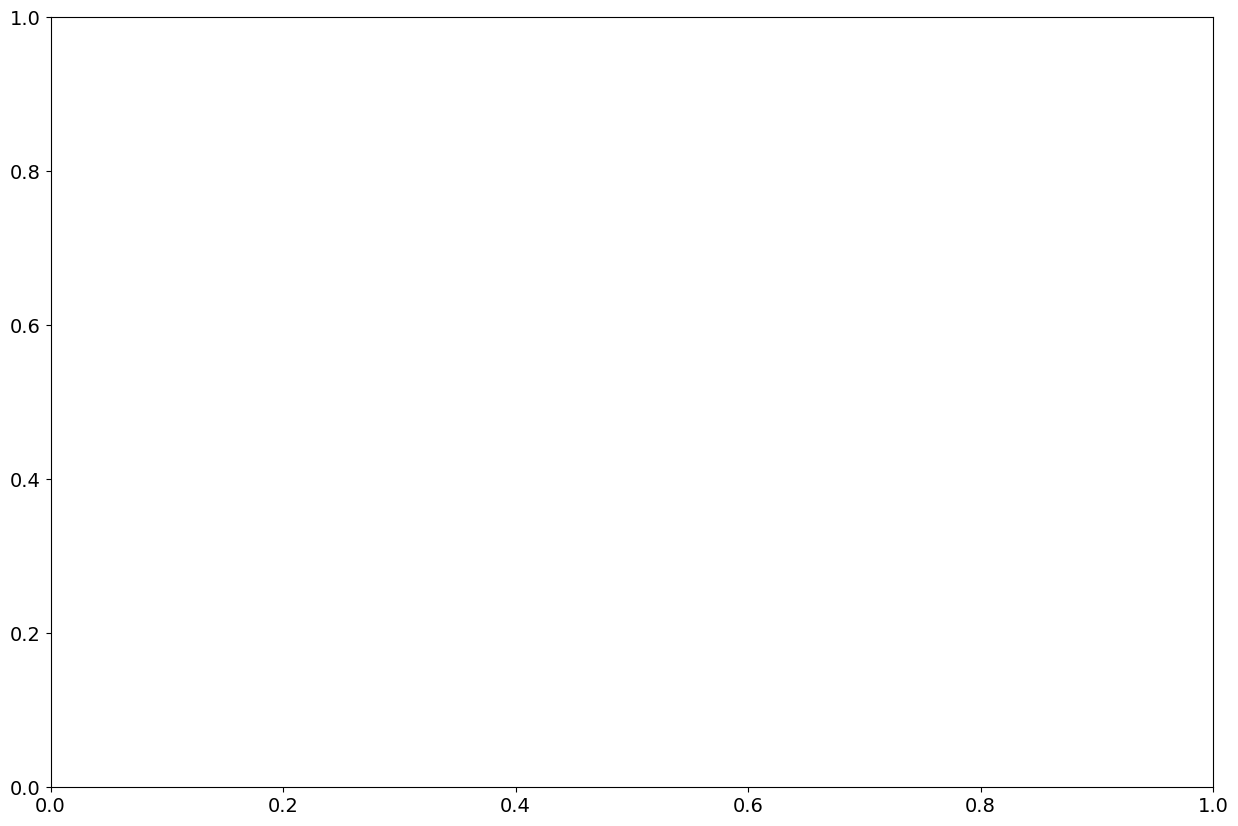

In [25]:
fig, ax = plt.subplots(figsize=(15,10), facecolor='w', edgecolor='k')
for i in range(5,6):
    print(i)
    dvf1=200#dvf1s[idx[i]]
    dvf2=300#dvf2s[idx[i]]
    dv=DVAC[i]#[8000::]
    X=np.concatenate((dv[0:25],dv[-25::]))
    z = np.polyfit(np.linspace(0,830,X.size), X, 2)
    p = np.poly1d(z)
    dv=dv-p(t2)
    ax.plot(t2,p(t2),'--r',label='Removed Compaction effect')
    #dv=signal.detrend(dv,0)
    t=tT#[8000::]
    t=np.linspace(0,5000/6,dv.size)
    ax.plot(t,dv,label=f'Monitored')#
    #Kernel=np.load(rf'C:\Hydro_modele\Kernel\Frequence\{dvf1}_{dvf2}\Kernel_{0}.npy')
    KernelPeff=np.load(rf'C:\Hydro_modele\Kernel\Frequence\Peff_52_{dvf1}_{dvf2}_Kernel_end.npy',allow_pickle=True)
    idxPeff=np.load(rf'C:\Hydro_modele\Kernel\Frequence\Peff_52_{dvf1}_{dvf2}_indice_end.npy',allow_pickle=True)
    KernelSol=np.load(rf'C:\Hydro_modele\Kernel\Frequence\Peff_50_{dvf1}_{dvf2}_Kernel_end.npy',allow_pickle=True)
    idxSol=np.load(rf'C:\Hydro_modele\Kernel\Frequence\Peff_50_{dvf1}_{dvf2}_indice_end.npy',allow_pickle=True)
    data=[]
    data2=[]
    for j in range(0,New_Depth.size):#depth.size-1):
        data.append(dvs2[j])
        data2.append(dvs1[j])
    print(np.shape(data))
    dvv=[]
    dvvsolazi=[]
    data=np.asarray(data)
    data2=np.asarray(data2)
    dvvPeff=[]
    for k in range(1400*6,1400*6+dv.size):
        index_kernelP=(find_nearest(idxPeff,k))
        index_kernelS=(find_nearest(idxSol,k))
        #if  np.trapz((KernelPeff[index_kernel][0:24]))!=1:
        #    KernelPeff[index_kernel][0:24]=Kernel[index_kernel][0:24]*(1/np.trapz((Kernel[index_kernel][0:24])))
        dvvPeff.append(np.trapz((KernelPeff[index_kernelP][0:24])*data[:,k]))
        idxmax=np.argmax(KernelPeff[index_kernelP])
        dvvsolazi.append(data[idxmax,k])
    tT=np.linspace(0,830,len(dvvPeff))
    #ax.plot(tT,dvvsolazi,'--',color='olive',label=f'Predicted Solazi {dvf1}-{dvf1+100} Hz')
    #ax.plot(tT,dvvsolazi,'--',color='olive',label=f'Predicted Max Kernel')
    ax.plot(tT,dvvPeff,'--',color='purple',label=f'Predicted Full Kernel')
    ax.legend(fontsize=15,loc=(0.465,0.725))
    ax.grid()
    ax.set(xlabel='Monitoring time (min)', xlim=[0,830],
           ylabel=r'$\delta v$ (%)', ylim=[-50,10])
    ax.set_xlabel('Monitoring time (min)',fontsize=20)
    ax.set_ylabel(r'$\frac{\delta v}{v}$ (%)',fontsize=25)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=15)
    ax.set_title(C[i],fontsize=20,y=1,fontweight="bold")
    ax.set_ylim(10,-50)
    DVPEFF.append(np.asarray(dvvPeff))
    ax.annotate(rf'{dvf1}-{dvf2} Hz', (2200, 4),
            xytext=(0.95, 0.1), textcoords='axes fraction',
            ha="right", va="top",
            bbox=dict(boxstyle="square",
                   ec=(0., 0, 0),
                   fc=(1., 1, 1),
                   )    ,        
            fontsize=20,
            horizontalalignment='right', verticalalignment='top')    #ax.plot(tT,DV[i],'--',color='purple',label=f'Predicted {dvf1}-{dvf1+100} Hz')

    n+=1
fig.tight_layout()

In [195]:
import numpy as np

from scipy.signal import savgol_filter

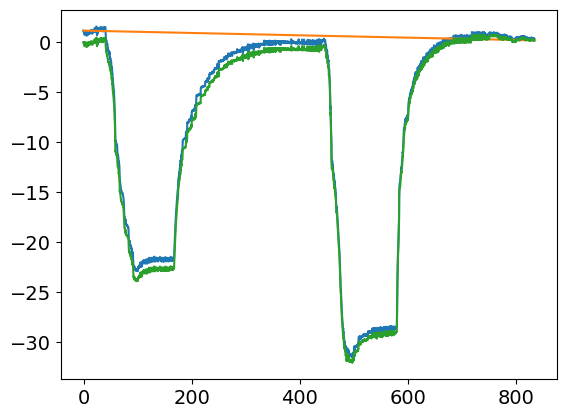

In [222]:
X=np.concatenate((dv[0:20],dv[-20::]))
z = np.polyfit(np.linspace(0,830,X.size), X, 1)
p = np.poly1d(z)
plt.plot(t2,dv)
plt.plot(t2,p(t2))
plt.plot(t2,dv-p(t2))

In [215]:
t2=np.linspace(0,5000/6,dv.size)

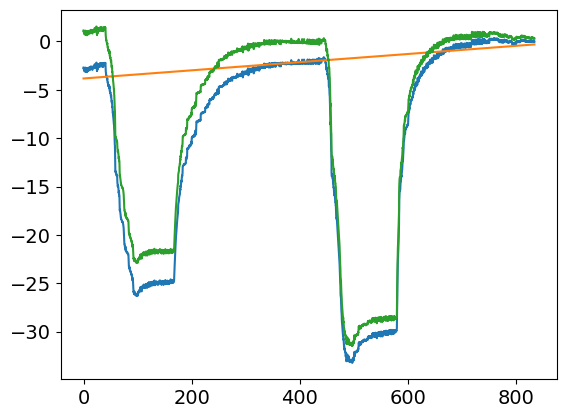

In [128]:
dv.size/6

833.3333333333334

In [373]:
d=np.asarray([0,3.7,6.7,9.8,14.6,18,24.1,28.7,33.6,39])*10**-2
D=[]
for i in range(d.size):
    for j in range(i+1,d.size):
        D.append(d[j]-d[i])

## Hysteresys 

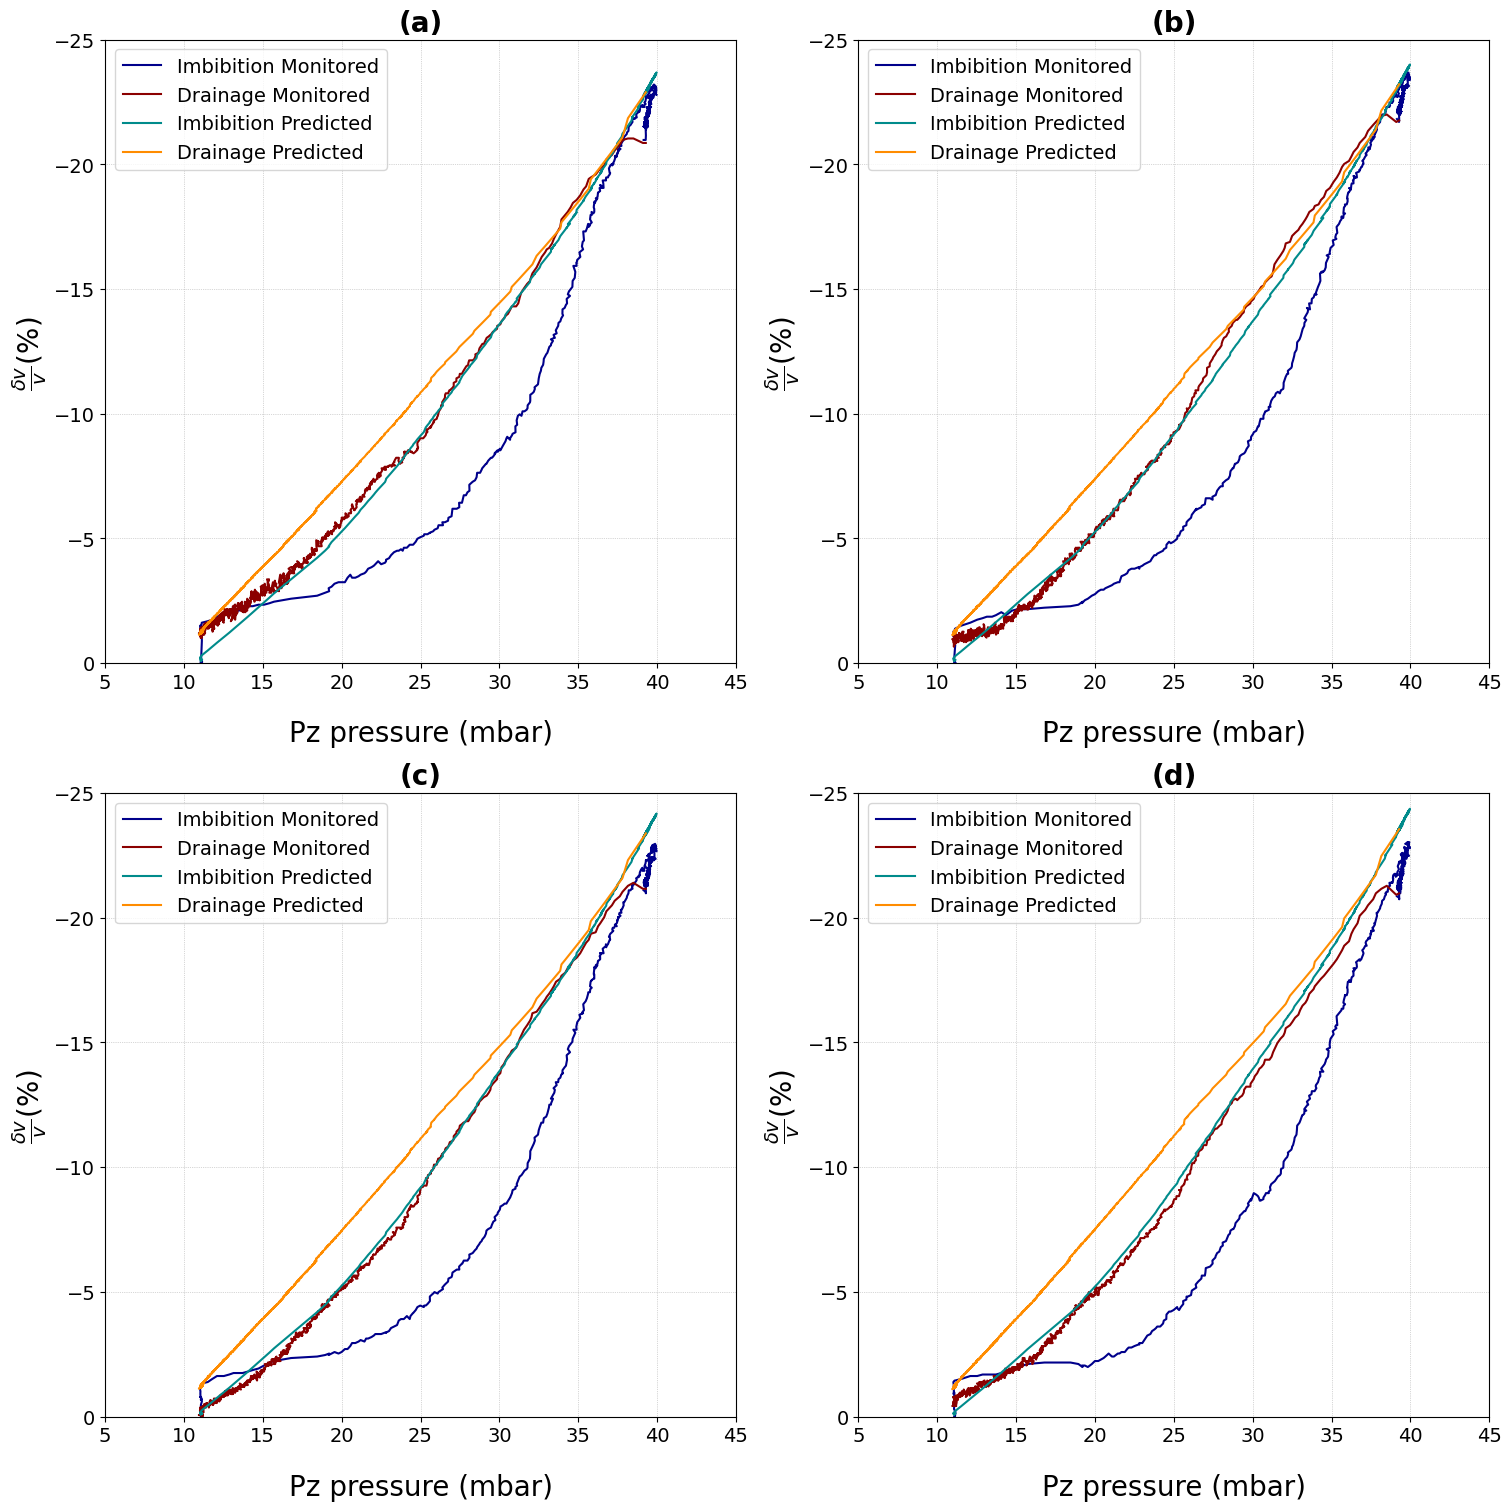

In [35]:
d=1
t1=59
t2=260
t3=320
t4=950
t5=1440
t6=1567#1723
t5d=1567
t6d=1723
t7=1840
t8=2100
t9=2100
t10=2300
ti=[t1,t3,t5,t7]
tf=[t2,t4,t6,t8]

#v=np.asarray([63.2,62.7,62.2,60.6,60.2,58.2,56.5,53.1,48.6,48.6,52.2,55.5,59,59.9,60.2,62.4,63,64.6])
#times=np.asarray([1440,1445,1448,1451,1453,1456,1465,1473,1490,1565,1570,1575,1585,1595,1605,1625,1648,1723])
dc_data=np.loadtxt(r'C:\Hydro_modele/vitesse400.txt')
dc_data=np.asarray(dc_data)
v=dc_data[:,1]
times=dc_data[:,0].astype('int')
T=np.linspace(0,72*60,72*60*6)
f,ax = plt.subplots(2,2,figsize=(15,15),constrained_layout=True)
ax=ax.ravel()
dvf1=200
dvf2=300
DV=np.asarray(DV)
k=2
l=0
d=np.asarray([0,3.7,6.7,9.8,14.6,18,24.1,28.7,33.6,39])*10**-2
D=[]
idx=np.asarray([2,3,4,5])
dvf1s=np.asarray([200,225,250,275,300,325,350,375])
dvf2s=np.asarray([200,225,250,275,300,325,350,375])+100
C=np.asarray(['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)'])
for i in range(idx.size):
    dvf1=dvf1s[idx[i]]
    dvf2=dvf2s[idx[i]]
    y=DVPEFF[i]#-dvff[i][1440*6]
    y=np.asarray(y)
    #im0=ax[i].scatter(Peff[k][(T>t5)&(T<t6)],y[(T>t5)&(T<t6)],c=T[(T>t5)&(T<t6)],s=10)
    ax[i].set_xlabel('Peff (Mpa)')
    ax[i].set_ylabel(r'$\delta v$ ')
    #ax[i].plot(Peff[2][(T>t5)&(T<t6)],dvff[idx[i]][(T>t5)&(T<t6)]-dvff[idx[i]][1440*6],'darkblue',label=f'Imbibition Monitored')#,linewidth=0.5)
    #ax[i].plot(Peff[2][(T>t5d)&(T<t6d)],dvff[idx[i]][(T>t5d)&(T<t6d)]-dvff[idx[i]][1440*6],'darkred',label=f'Drainage Monitored')#,linewidth=0.5)

    #ax[i].plot(Peff[2][(T>t5)&(T<t6)],y[(T>t5)&(T<t6)],color='darkcyan',label=f'Imbibition Predicted')#,linewidth=0.5)
    #ax[i].plot(Peff[2][(T>t5d)&(T<t6d)],y[(T>t5d)&(T<t6d)],color='darkorange',label=f'Drainage Predicted')#,linewidth=0.5)
    ax[i].plot(Pw[(T>t5)&(T<t6)],dvff[idx[i]][(T>t5)&(T<t6)]-dvff[idx[i]][1440*6],'darkblue',label=f'Imbibition Monitored')#,linewidth=0.5)
    ax[i].plot(Pw[(T>t5d)&(T<t6d)],dvff[idx[i]][(T>t5d)&(T<t6d)]-dvff[idx[i]][1440*6],'darkred',label=f'Drainage Monitored')#,linewidth=0.5)

    ax[i].plot(Pw[(T>t5)&(T<t6)],y[(T>t5)&(T<t6)],color='darkcyan',label=f'Imbibition Predicted')#,linewidth=0.5)
    ax[i].plot(Pw[(T>t5d)&(T<t6d)],y[(T>t5d)&(T<t6d)],color='darkorange',label=f'Drainage Predicted')#,linewidth=0.5)
    ax[i].legend(fontsize=14)
    ax[i].grid()
    ax[i].set_xlabel('Pz pressure (mbar)',fontsize=20, labelpad=20)

#   ax[i].set_xlabel('Effective Pressure (MPa)',fontsize=20, labelpad=20)
    ax[i].set_ylabel(r'$\frac{\delta v}{v} (\%)$ ',fontsize=20)
    ax[i].set_title(f'{C[i]}',fontsize=20,y=1,fontweight="bold")
    ax[i].tick_params(axis='both', which='minor', labelsize=15)
    #ax[i].set_aspect(0.00012)
    ax[i].set_ylim(0,-25)
    #ax[i].set_xlim(0.0045,0.0015)
    ax[i].set_xlim(5,45)

    #ax[i].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    ax[i].annotate(rf'{dvf1}-{dvf2} Hz', (2e-3, -2),
            xytext=(0.95, 0.1), textcoords='axes fraction',
            ha="right", va="top",
            bbox=dict(boxstyle="square",
                   ec=(0., 0, 0),
                   fc=(1., 1, 1),
                   )    ,        
            fontsize=20,
            horizontalalignment='right', verticalalignment='top')
    #    ax[1].set_title('(b)',fontsize=20,y=1,fontweight="bold")
plt.savefig('F:\Fig_to_make/Hysteresys_brutePz.pdf',format='pdf',bbox_inches='tight',dpi=300)
plt.savefig('F:\Fig_to_make/Hysteresys_brutePz.jpg',format='jpg',bbox_inches='tight',dpi=300)


In [120]:
len(DVPEFF)

4

In [298]:
ax[i].get_images()

<a list of 0 AxesImage objects>

## Fluids Flow theorical

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\tgaubert001\.conda\envs\Acquisition\lib\site-packages\ipykernel_launcher.py:67: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "*k" (-> color='k'). The keyword argument will take precedence.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(15, 25920) (8, 25920)
400


C:\Users\tgaubert001\.conda\envs\Acquisition\lib\site-packages\ipykernel_launcher.py:119: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "*k" (-> color='k'). The keyword argument will take precedence.
C:\Users\tgaubert001\.conda\envs\Acquisition\lib\site-packages\ipykernel_launcher.py:120: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "*k" (-> color='k'). The keyword argument will take precedence.


(250.0, 475.0)

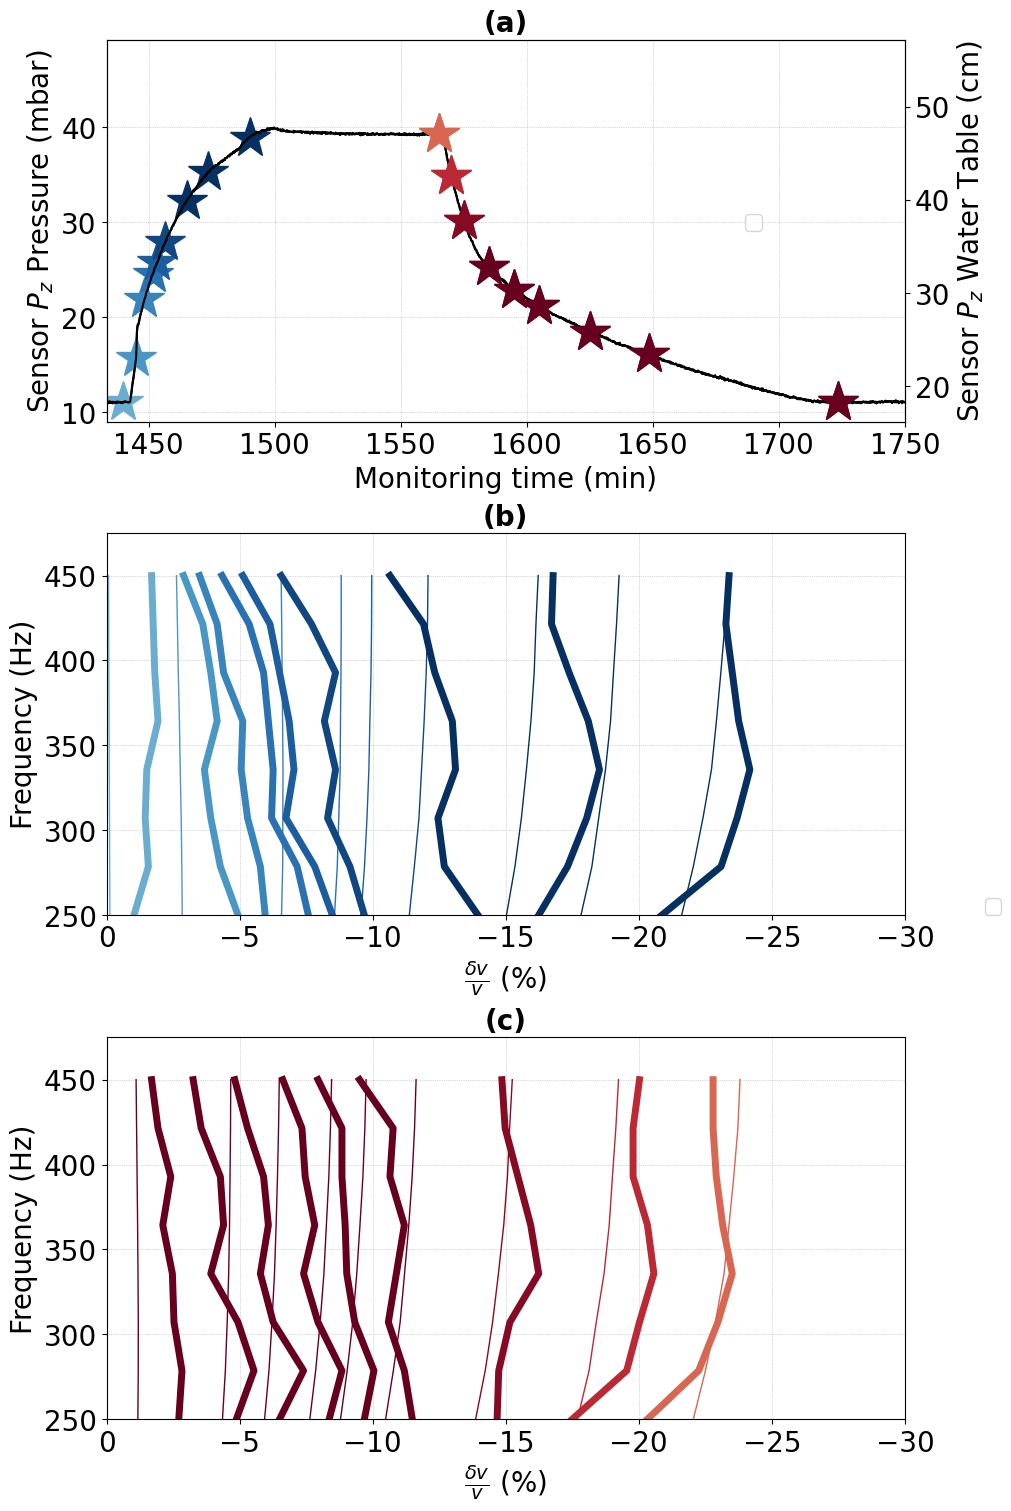

In [218]:
fig, ax = plt.subplots(3,1,figsize=(10,15), facecolor='w', edgecolor='k',constrained_layout=True)
Sw,Pw,Pf,Depth=np.load(r'F:/Saturation_Pw_Pf_depth_Clarisse2.npy',allow_pickle=True)
#dvff=np.load('G:/Final_frequency_dv.npy')Final_frequency_dv_15_trace
dvff=np.load('G:/Final_frequency_dv_15_trace.npy')
D=np.asarray(dvff)
DV=np.asarray(dvff)
import numpy as np
import matplotlib as mpl
import matplotlib.pylab as plt
t=np.linspace(0,72*60,DV[0].size)
ax2=ax[0]
ax1=ax[1]
ax3=ax[2]
K=750
i1=8640#8640#9390#93608640
#i1=9390#8640#9390#93608640

k1=400
k2=800
K=k1

from matplotlib import cm
new_cmap=cm.get_cmap('RdBu_r',25)#brg
Y=[]
dvf1=200
dvf2=300
F=np.linspace(250,650,15)
print(np.shape(DV),np.shape(DVPEFF))
for i in range(len(DVPEFF)):
        x=np.zeros(K)+F[i]
        y=DV[i,i1:i1+x.size]
        y=(y)
        Y.append(y)
        dvf1+=25
        dvf2+=25
dvf1=200
dvf2=300
F=np.linspace(250,650,15)
F=F[0:len(DVPEFF)]
Theoriques=[]
DVPEFF=np.asarray(DVPEFF)
for i in range(len(DVPEFF)):
        x=np.zeros(K)+F[i]
        Theorique=DVPEFF[i,i1:i1+x.size]
        y=(Theorique)
        Theoriques.append(y)
        dvf1+=25
        dvf2+=25    

ax1.legend(loc=(1.1,0),fontsize=15,ncol=4)
ax1.set_xlabel(r'$\frac{\delta v}{v}$ (%)',fontsize=20)
ax1.grid()
ax1.set_ylabel('Frequency (Hz)',fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=20)
Y=np.asarray(Y)
val_camp=[]
idx=0
print(K)
times=[]
Theoriques=np.asarray(Theoriques)
C=np.asarray([0,30,50,70,80,100,150,200,300])
for i in range(C.size):
    ax1.plot(Y[:,C[i]],F[:],color=new_cmap(6-idx),linewidth=5,markersize=20)
    ax1.plot(Theoriques[:,C[i]],F[:],color=new_cmap(6-idx),linewidth=1,markersize=20)
    x=F[:]
    z=Y[:,i*6]
    ax2.plot(t[i1+C[i]],Pw[i1+C[i]],'*k',color=new_cmap(6-idx),markersize=30,zorder=2)
    x=F[:]
    z=Y[:,i*6]
    times.append(i1+C[i])
    idx+=1

t=np.linspace(0,72*60,Pw.size)
ax2.plot(t,Pw,'k',zorder=1)
ax2t=ax2.twinx()
ax2t.plot(t,7+1.019*Pw,'k',zorder=1)


    
    

ax2.set_xlabel('Monitoring time (min)',fontsize=20)
ax2.set_ylabel(r'Sensor $P_{z}$ Pressure (mbar)',fontsize=20)
ax2t.set_ylabel(r'Sensor $P_{z}$ Water Table (cm)',fontsize=20)
ax2t.tick_params(axis='both', which='major', labelsize=20)

ax2.grid()
ax2.legend(fontsize=15,loc=(0.8,0.5))
K=k2+200

ax2.set_xlim(8640/6,((9360)/6)+K/6)
i1=9390
Y=[]
idx+=10
Theoriques=[]
for i in range(len(DVPEFF)):
        x=np.zeros(K)+F[i]
        y=DV[i,i1:i1+x.size]
        y=(y)
        Y.append(y)
        x=np.zeros(K)+F[i]
        Theorique=DVPEFF[i,i1:i1+x.size]
        y=(Theorique)
        Theoriques.append(y)
        dvf1+=25
        dvf2+=25


Theoriques=np.asarray(Theoriques)

Y=np.asarray(Y)
C=np.asarray([0,30,60,120,180,240,360,500,950])
for i in range(C.size):
    ax3.plot(Theoriques[:,C[i]],F[:],color=new_cmap([idx]),linewidth=1,markersize=20)
    ax3.plot(Y[:,C[i]],F[:],color=new_cmap([idx]),linewidth=5,markersize=20)
    x=F[:]
    z=Y[:,C[i]]
    times.append(i1+C[i])
    ax2.plot(t[i1+C[i]],Pw[i1+C[i]],'*k',color=new_cmap([idx]),markersize=30,zorder=2)
    ax2t.plot(t[i1+C[i]],7+1.019*Pw[i1+C[i]],'*k',color=new_cmap([idx]),markersize=30,zorder=2)
    idx+=2
ax[0].set_title('(a)',fontsize=20,y=1,fontweight="bold")
ax[1].set_title('(b)',fontsize=20,y=1,fontweight="bold")
ax[2].set_title('(c)',fontsize=20,y=1,fontweight="bold")
ax[2].tick_params(axis='both', which='major', labelsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=20)
ax[0].tick_params(axis='both', which='major', labelsize=20)
ax3.set_xlabel(r'$\frac{\delta v}{v}$ (%)',fontsize=20)
ax3.grid()
ax3.set_ylabel('Frequency (Hz)',fontsize=20)
ax2.set_xlim(8600/6,1750)
ax1.set_xlim(0,-30)
ax3.set_xlim(0,-30)
ax1.set_ylim(250,475)
ax3.set_ylim(250,475)

#plt.savefig(rf'F:\Fig_to_make/Fluidsflow_200_475.pdf',format='pdf',dpi=300)
#plt.savefig(rf'F:\Fig_to_make/Fluidsflow_200_475.jpg',format='jpg',dpi=300)



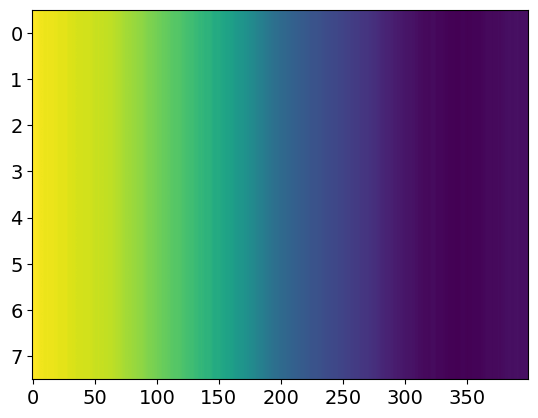

In [211]:
plt.imshow(Theoriques,aspect='auto')
plt.xlim(8500,10000)

In [214]:
len(DVPEFF)

8

## Hysteresys SAW